In [ ]:
%reset -sf

import tensorflow as tf
print("Tensorflow:", tf.__version__)
import tensorflow_probability as tfp
print("Tensorflow Probability:", tfp.__version__)
# tf.config.run_functions_eagerly(True) # use for print numpy in tf functions (debugging)
# GPU(s) setups
gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[1], True)
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.set_visible_devices(gpus[1], 'GPU')
        
        # Enable memory growth for the first GPU
        tf.config.experimental.set_memory_growth(gpus[1], True)
        
        # Instead of enabling memory growth, set a memory limit
        # memory_limit = 16_376 / 3 # Set the memory limit in MB
        memory_limit = -1
        if memory_limit >= 0:
            tf.config.experimental.set_virtual_device_configuration(
                gpus[1],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)]
            )
            
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

2025-03-06 16:56:59.788703: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow: 2.13.0
Tensorflow Probability: 0.21.0
2 Physical GPUs, 1 Logical GPU


2025-03-06 16:57:03.342232: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46696 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6


In [1]:
import sys
import os
import glob

HOME_PATH = os.path.abspath("..")
sys.path.insert(0, HOME_PATH + "/qe")

import paper_plot as pp

plot = pp.Plotter()

import pandas as pd
import numpy as np
import scipy as sp
import ROOT
from ROOT import TLorentzVector, TVector3
import multiprocessing
WORKERS = 16

from matplotlib import pyplot as plt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"  # suppress tensorflow imformation messages

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import cauchy, skewcauchy, skewnorm

SEED = 42  # set random seed (global variable)
GEV = 1e-3

Welcome to JupyROOT 6.28/04


In [2]:
import full_data as data

# reco
lead_lep = data.Lead_lep()
sublead_lep = data.Sublead_lep()
met = data.Met()

# truth
truth_lead_lep = data.Truth_lead_lep()
truth_sublead_lep = data.Truth_sublead_lep()
Truth_dilep = data.Truth_dilep()
truth_met = data.Truth_met()

# target Ws
w_lead = data.Lead_w()
w_sublead = data.Sublead_w()
mc_weight = data.MC_weight()

['/CGLMP', '/RecoLep0', '/RecoLep1', '/RecoMET', '/TruthCandLep0', '/TruthCandLep1', '/TruthCandMET', '/TruthHiggs', '/TruthLep0', '/TruthLep1', '/TruthLepN', '/TruthLepP', '/TruthNu0', '/TruthNu1', '/TruthNuN', '/TruthNuP', '/TruthW0', '/TruthW1', '/TruthWN', '/TruthWP', '/eventWeight', '/mcWeight', '/recoWeight', '/weight']


In [3]:
# define preselection cuts

cut_pre_pt_lead = lead_lep.pt > 22 # 22 ~ 40 (SY)
print(len(lead_lep.energy) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = sublead_lep.pt > 15
print(len(lead_lep.energy) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.sqrt(
        np.square(lead_lep.energy + sublead_lep.energy)
        - np.square(lead_lep.px + sublead_lep.px)
        - np.square(lead_lep.py + sublead_lep.py)
        - np.square(lead_lep.pz + sublead_lep.pz)
    )
    > 10
)
print(len(lead_lep.energy) - np.sum(cut_pre_dilep_m * 1))
cut_pre_pt_miss = met.pt > 20
print(len(lead_lep.energy) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print(len(lead_lep.energy) - np.sum(PRE_CUT * 1))
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

# # define preselection cuts

# cut_pre_pt_lead = lead_lep.pt > -9999
# print(len(lead_lep.energy) - np.sum(cut_pre_pt_lead * 1))
# cut_pre_pt_sub = sublead_lep.pt > -9999
# print(len(lead_lep.energy) - np.sum(cut_pre_pt_sub * 1))
# cut_pre_dilep_m = (
#     np.sqrt(
#         np.square(lead_lep.energy + sublead_lep.energy)
#         - np.square(lead_lep.px + sublead_lep.px)
#         - np.square(lead_lep.py + sublead_lep.py)
#         - np.square(lead_lep.pz + sublead_lep.pz)
#     )
#     > -9999
# )
# print(len(lead_lep.energy) - np.sum(cut_pre_dilep_m * 1))
# cut_pre_pt_miss = met.pt > -9999
# print(len(lead_lep.energy) - np.sum(cut_pre_pt_miss * 1))
# PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
# print(len(lead_lep.energy) - np.sum(PRE_CUT * 1))
# del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)


0
29961
44269
89634
157782


In [4]:

def eta(px, py, pz):
    pt = np.sqrt(np.square(px) + np.square(py))
    return np.arcsinh(np.divide(pz, pt))


def phi(px, py):
    return np.arctan2(py, px)


def deta(eta1, eta2):
    return np.abs(eta1 - eta2)


def dphi_pi(phi1, phi2):
    phi_diff = phi1 - phi2
    phi_diff = np.where(phi_diff < 0.0, -phi_diff, phi_diff)
    phi_diff = np.where(phi_diff > 2.0 * np.pi, phi_diff - 2.0 * np.pi, phi_diff)
    phi_diff = np.where(phi_diff >= np.pi, 2.0 * np.pi - phi_diff, phi_diff)
    return np.divide(phi_diff, np.pi)

In [5]:
# truth
truth_lead_lep_px = pd.DataFrame(truth_lead_lep.px[PRE_CUT])
truth_lead_lep_py = pd.DataFrame(truth_lead_lep.py[PRE_CUT])
truth_lead_lep_pz = pd.DataFrame(truth_lead_lep.pz[PRE_CUT])
truth_lead_lep_energy = pd.DataFrame(truth_lead_lep.energy[PRE_CUT])
truth_lead_lep_p4 = pd.concat(
	[truth_lead_lep_px, truth_lead_lep_py, truth_lead_lep_pz, truth_lead_lep_energy],
	axis=1,
).to_numpy()
truth_sublead_lep_px = pd.DataFrame(truth_sublead_lep.px[PRE_CUT])
truth_sublead_lep_py = pd.DataFrame(truth_sublead_lep.py[PRE_CUT])
truth_sublead_lep_pz = pd.DataFrame(truth_sublead_lep.pz[PRE_CUT])
truth_sublead_lep_energy = pd.DataFrame(truth_sublead_lep.energy[PRE_CUT])
truth_sublead_lep_p4 = pd.concat(
	[truth_sublead_lep_px, truth_sublead_lep_py, truth_sublead_lep_pz, truth_sublead_lep_energy],
	axis=1,
).to_numpy()
truth_dilep_dphi = pd.DataFrame(truth_lead_lep.phi[PRE_CUT] - truth_sublead_lep.phi[PRE_CUT])
truth_dilep_deta = pd.DataFrame(truth_lead_lep.eta[PRE_CUT] - truth_sublead_lep.eta[PRE_CUT])
# reco
lead_lep_px = pd.DataFrame(lead_lep.px[PRE_CUT])
lead_lep_py = pd.DataFrame(lead_lep.py[PRE_CUT])
lead_lep_pz = pd.DataFrame(lead_lep.pz[PRE_CUT])
lead_lep_energy = pd.DataFrame(lead_lep.energy[PRE_CUT])
lead_lep_p4 = pd.concat(
	[lead_lep_px, lead_lep_py, lead_lep_pz, lead_lep_energy],
	axis=1,
).to_numpy()
sublead_lep_px = pd.DataFrame(sublead_lep.px[PRE_CUT])
sublead_lep_py = pd.DataFrame(sublead_lep.py[PRE_CUT])
sublead_lep_pz = pd.DataFrame(sublead_lep.pz[PRE_CUT])
sublead_lep_energy = pd.DataFrame(sublead_lep.energy[PRE_CUT])
sublead_lep_p4 = pd.concat(
	[sublead_lep_px, sublead_lep_py, sublead_lep_pz, sublead_lep_energy],
	axis=1,
).to_numpy()
met_px = pd.DataFrame(met.px[PRE_CUT])
met_py = pd.DataFrame(met.py[PRE_CUT])
met_phi = pd.DataFrame(met.phi[PRE_CUT])
dilep_dphi = dphi_pi(lead_lep.phi[PRE_CUT], sublead_lep.phi[PRE_CUT])
dilep_deta = deta(lead_lep.eta[PRE_CUT], sublead_lep.eta[PRE_CUT])

In [6]:

## Observing variables

obs_kin = np.column_stack(
    (
        lead_lep_px,
        lead_lep_py,
        lead_lep_pz,
        lead_lep_energy,
        sublead_lep_px,
        sublead_lep_py,
        sublead_lep_pz,
        sublead_lep_energy,
        met_px,
        met_py,
        # met_phi,
        # dilep_deta,
        # dilep_dphi,
        # np.log(sublead_lep.energy),
        # np.log(lead_lep.energy),
        # lead_lep.eta,
        # sublead_lep.eta,
    )
)

# Kinematics of observing variables (inputs for training)
print("int_kin shape:", obs_kin.shape)
# print(print(obs_kin.describe()))
# obs_kin = obs_kin.to_numpy() # convert to numpy array

# ROBUST_OBS = RobustScaler()
# obs_kin = ROBUST_OBS.fit_transform(obs_kin)
# print(type(obs_kin))

int_kin shape: (851115, 10)


In [7]:
## Interesting variables

w_lead_px = pd.DataFrame(w_lead.px[PRE_CUT])
w_lead_py = pd.DataFrame(w_lead.py[PRE_CUT])
w_lead_pz = pd.DataFrame(w_lead.pz[PRE_CUT])
w_lead_e = pd.DataFrame(w_lead.energy[PRE_CUT])
w_lead_log_e = pd.DataFrame(np.log(w_lead_e))
w_lead_sqrt_e = pd.DataFrame(np.sqrt(w_lead_e))
w_sublead_px = pd.DataFrame(w_sublead.px[PRE_CUT])
w_sublead_py = pd.DataFrame(w_sublead.py[PRE_CUT])
w_sublead_pz = pd.DataFrame(w_sublead.pz[PRE_CUT])
w_sublead_e = pd.DataFrame(w_sublead.energy[PRE_CUT])
w_sublead_log_e = pd.DataFrame(np.log(w_sublead_e))
w_sublead_sqrt_e = pd.DataFrame(np.sqrt(w_sublead_e))
w_lead_m = pd.DataFrame(w_lead.m[PRE_CUT])
w_sublead_m = pd.DataFrame(w_sublead.m[PRE_CUT])

# Kinematics of interesting variables (target for training)
int_kin = np.concatenate(
    [
        w_lead_px,
        w_lead_py,
        w_lead_pz,
        w_lead_e,
        w_sublead_px,
        w_sublead_py,
        w_sublead_pz,
        w_sublead_e,
        # np.square(w_lead_m) / np.mean(w_lead_m),
        # np.square(w_sublead_m) / np.mean(w_lead_m),
        # w_lead_m,
        # w_sublead_m,
    ],
    axis=-1,
)
print("int_kin shape:", int_kin.shape)
# int_kin = int_kin.to_numpy()  # convert to numpy array
print(type(int_kin))

int_kin shape: (851115, 8)
<class 'numpy.ndarray'>


In [8]:
# padding for INN
# padd to the same shape of obs_kin using multivariates normal distributions
pad_dim = obs_kin.shape[1] - int_kin.shape[1]
z = np.random.multivariate_normal([0.]*pad_dim, 10000*np.eye(pad_dim), int_kin.shape[0])
# int_kin
int_kin = np.concatenate([int_kin, z], axis=-1)

In [9]:
# Train test split

indices_arr = np.arange(int_kin.shape[0], dtype="int")
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.8,
    test_size=0.2,
    random_state=SEED,
    shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=SEED
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
valid_x = obs_kin[valid_indices]
# test_x = np.concatenate([test_x, valid_x], axis=0)

train_y = int_kin[train_indices]
test_y = int_kin[test_indices]
valid_y = int_kin[valid_indices]
# test_y = np.concatenate([test_y, valid_y], axis=0)

print("Total evts:", len(indices_arr))
print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)

Total evts: 851115
X (Interest)
Training data shape: (680892, 10);
Validing data shape: (85111, 10);
Testing data shape: (85112, 10).
Y (Observed)
Training data shape: (680892, 10);
Validing data shape: (85111, 10);
Testing data shape: (85112, 10).


In [10]:
# training variables
BATCH_SIZE = 512
EPOCHS = 1024
LEARNING_RATE = 1e-5

# create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(train_x, tf.float32), 
    tf.cast(train_y, tf.float32)
)).cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(valid_x, tf.float32), 
    tf.cast(valid_y, tf.float32)
)).cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

NameError: name 'tf' is not defined

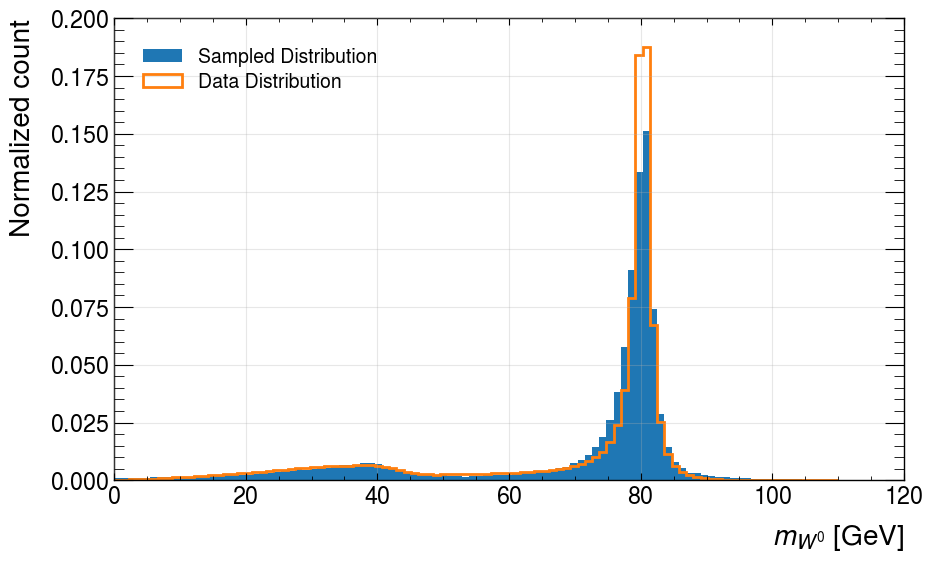

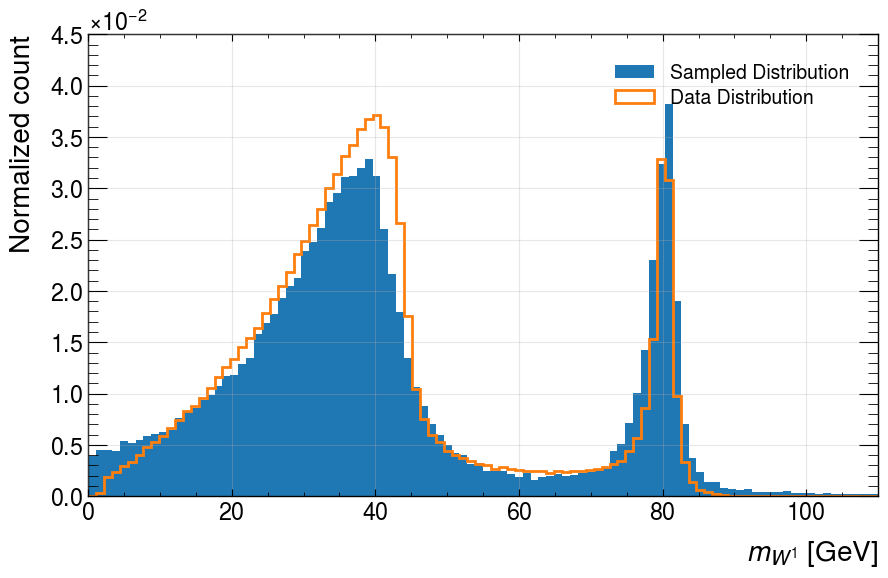

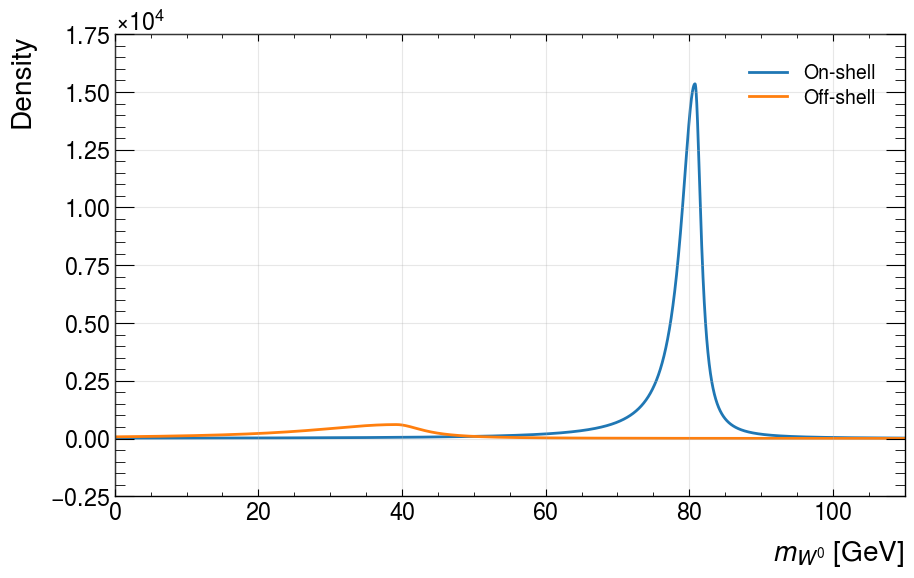

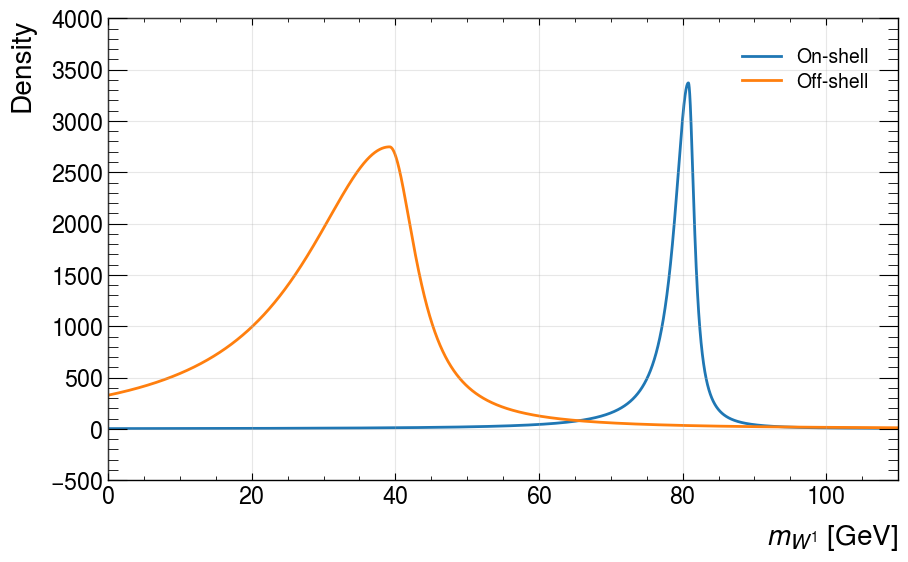

In [ ]:
# Sampling parameters (consistent with your data)
mmd_rbf_sigma = 1.0
n_samples = 100000
on_shell_fraction = 0.82
n_on_shell = int(n_samples * on_shell_fraction)
n_off_shell = n_samples - n_on_shell 
on_shell_loc = 80.8
on_shell_scale = 1.7
on_shell_skew = -0.4
off_shell_loc = 39.2
off_shell_scale = 9.5
off_shell_skew = -0.52

# Generate sampled distribution for reference (optional validation)
# lead
on_shell_lead_samples = skewcauchy.rvs(a=on_shell_skew, loc=on_shell_loc, scale=on_shell_scale, size=n_on_shell)
off_shell_lead_samples = skewcauchy.rvs(a=off_shell_skew, loc=off_shell_loc, scale=off_shell_scale, size=n_off_shell)
off_shell_lead_samples = off_shell_lead_samples[
    (off_shell_lead_samples >= 0) & (off_shell_lead_samples <= 125)
]
lead_samples = np.concatenate([on_shell_lead_samples, off_shell_lead_samples])
lead_samples = lead_samples[(lead_samples >= 0) & (lead_samples <= 110)]
# sublead
on_shell_sublead_samples = skewcauchy.rvs(a=on_shell_skew, loc=on_shell_loc, scale=on_shell_scale, size=n_off_shell)
off_shell_sublead_samples = skewcauchy.rvs(a=off_shell_skew, loc=off_shell_loc, scale=off_shell_scale, size=n_on_shell)
off_shell_sublead_samples = off_shell_sublead_samples[
    (off_shell_sublead_samples >= 0) & (off_shell_sublead_samples <= 125)
]
sublead_samples = np.concatenate([on_shell_sublead_samples, off_shell_sublead_samples])
sublead_samples = sublead_samples[(sublead_samples >= 0) & (sublead_samples <= 110)]

# Plotting the sampled and data distribution
# leading
plt.figure(figsize=(10, 6))
bins_edges = np.linspace(0, 110, 101)
plt.hist(
    lead_samples,
    bins=bins_edges,
    color="tab:blue",
    alpha=1.0,
    label="Sampled Distribution",
    density=True,
)
plt.hist(
    w_lead_m,
    bins=bins_edges,
    color="tab:orange",
    histtype="step",
    linewidth=2,
    alpha=1.0,
    label="Data Distribution",
    density=True,
)
plt.xlabel(r"$m_{W^{0}}$ [GeV]")
plt.ylabel("Normalized count")
# plt.semilogy()
# plt.xlim(0, 110)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
# offshell
plt.figure(figsize=(10, 6))
bins_edges = np.linspace(0, 110, 101)
plt.hist(
    sublead_samples,
    bins=bins_edges,
    color="tab:blue",
    alpha=1.0,
    label="Sampled Distribution",
    density=True,
)
plt.hist(
    w_sublead_m,
    bins=bins_edges,
    color="tab:orange",
    histtype="step",
    linewidth=2,
    alpha=1.0,
    label="Data Distribution",
    density=True,
)
plt.xlabel(r"$m_{W^{1}}$ [GeV]")
plt.ylabel("Normalized count")
plt.grid(True, alpha=0.3)
plt.xlim(0, 110)
plt.legend()
plt.show()

# Plot PDF for visual inspection
x = np.linspace(0, 110, n_samples)
# leading
plt.figure(figsize=(10, 6))
plt.plot(
    x, skewcauchy.pdf(x, a=on_shell_skew, loc=on_shell_loc, scale=on_shell_scale) * n_on_shell, label="On-shell"
)
plt.plot(
    x, skewcauchy.pdf(x, a=off_shell_skew, loc=off_shell_loc, scale=off_shell_scale) * n_off_shell, label="Off-shell",
)
plt.xlabel(r"$m_{W^{0}}$ [GeV]")
plt.ylabel("Density")
plt.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.xlim(0, 110)
plt.show()
# subleading
plt.figure(figsize=(10, 6))
plt.plot(
    x, skewcauchy.pdf(x, a=on_shell_skew, loc=on_shell_loc, scale=on_shell_scale) * n_off_shell, label="On-shell"
)
plt.plot(
    x, skewcauchy.pdf(x, a=off_shell_skew, loc=off_shell_loc, scale=off_shell_scale) * n_on_shell, label="Off-shell",
)
plt.xlabel(r"$m_{W^{1}}$ [GeV]")
plt.ylabel("Density")
plt.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.xlim(0, 110)
plt.show()

# Define the anticipated distribution shape (mixture model)
x_grid = tf.linspace(0.0, 110.0, n_samples)
x_grid = tf.cast(x_grid, dtype=tf.float32) # Explicitly set dtype
# leading
on_shell_lead_pdf = skewcauchy.pdf(x_grid, a=on_shell_skew, loc=on_shell_loc, scale=on_shell_scale) * on_shell_fraction
off_shell_lead_pdf = skewcauchy.pdf(x_grid, a=off_shell_skew, loc=off_shell_loc, scale=off_shell_scale) * (
    1.0 - on_shell_fraction
)
total_lead_pdf = on_shell_lead_pdf + off_shell_lead_pdf
total_lead_pdf = total_lead_pdf / tf.reduce_max(total_lead_pdf)  # Normalize
total_lead_pdf_tf = tf.cast(total_lead_pdf, dtype=tf.float32)  # Ensure consistent dtype
# subleading
on_shell_sublead_pdf = skewcauchy.pdf(x_grid, a=on_shell_skew, loc=on_shell_loc, scale=on_shell_scale) * (
    1.0 - on_shell_fraction
)
off_shell_sublead_pdf = skewcauchy.pdf(x_grid, a=off_shell_skew, loc=off_shell_loc, scale=off_shell_scale) * on_shell_fraction
total_sublead_pdf = on_shell_sublead_pdf + off_shell_sublead_pdf
total_sublead_pdf = total_sublead_pdf / tf.reduce_max(total_sublead_pdf)  # Normalize
total_sublead_pdf_tf = tf.cast(total_sublead_pdf, dtype=tf.float32)  # Ensure consistent dtype


# Loss functions

def gaussian_kernel(x, y, sigma=mmd_rbf_sigma):
    x = tf.expand_dims(x, axis=1)  # Shape: (N,1,D)
    y = tf.expand_dims(y, axis=0)  # Shape: (1,M,D)
    pairwise_sq_dist = tf.reduce_sum(tf.square((x - y)), axis=-1)
    return tf.exp(-pairwise_sq_dist / (2.0 * tf.square(sigma)))

def compute_mmd(x_samples, y_samples, sigma=mmd_rbf_sigma):
    k_xx = gaussian_kernel(x_samples, x_samples, sigma)
    k_yy = gaussian_kernel(y_samples, y_samples, sigma)
    k_xy = gaussian_kernel(x_samples, y_samples, sigma)
    mmd = tf.reduce_mean(k_xx) + tf.reduce_mean(k_yy) - 2 * tf.reduce_mean(k_xy)
    return mmd

def w_mass_loss_fn(y_pred):
    y_pred = tf.cast(y_pred, tf.float32)
    w0_4Vect = y_pred[..., :4]
    w1_4Vect = y_pred[..., 4:8]
    
    w0_mass = tf.sqrt(
        tf.math.maximum(
            tf.abs(
                tf.square(w0_4Vect[..., 3])
                - tf.reduce_sum(tf.square(w0_4Vect[..., :3]), axis=-1)
            ),
            1e-10,
        )
    )
    # w1_mass = tf.sqrt(
    #     tf.math.maximum(
    #         tf.abs(
    #             tf.square(w1_4Vect[..., 3])
    #             - tf.reduce_sum(tf.square(w1_4Vect[..., :3]), axis=-1)
    #         ),
    #         1e-10,
    #     )
    # )

    # NLL for the anticipated distribution shape
    pred_lead_masses = tf.reshape(w0_mass, [-1])  # Focus on w0_mass
    pred_lead_pdf = tfp.math.interp_regular_1d_grid(
        pred_lead_masses, 0.0, 110.0, total_lead_pdf_tf, fill_value="constant_extension"
    )
    # pred_sublead_masses = tf.reshape(w1_mass, [-1])  # Focus on w1_mass
    # pred_sublead_pdf = tfp.math.interp_regular_1d_grid(
    #     pred_sublead_masses, 0.0, 110.0, total_sublead_pdf_tf, fill_value="constant_extension"
    # )
    # Negative log-likelihood penalty
    w0_nll = -tf.reduce_mean(tf.math.log(pred_lead_pdf + 1e-10))
    # w1_nll = -tf.reduce_mean(tf.math.log(pred_sublead_pdf + 1e-10))
    # nll = w0_nll + w1_nll
    
    # MMD 
    # pred_lead_masses = tf.reshape(w0_mass, [-1]) # Focus on w0_mass
    # true_lead_masses = tf.convert_to_tensor(lead_samples, dtype=tf.float32)  # Reference distribution

    # return compute_mmd(pred_lead_masses, true_lead_masses, sigma=mmd_rbf_sigma)
    return w0_nll


def nu_mass_loss_fn(x_batch, y_pred):
    _epsilon = 1e-10
    x_batch = tf.cast(x_batch, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    n0_4vect = y_pred[..., :4] - x_batch[..., :4]
    n1_4vect = y_pred[..., 4:8] - x_batch[..., 4:8]

    nu0_mass = tf.sqrt(
        tf.math.maximum(
            tf.abs(
                tf.square(n0_4vect[..., 3])
                - tf.reduce_sum(tf.square(n0_4vect[..., :3]), axis=-1)
            ),
            _epsilon,
        )
    )
    nu1_mass = tf.sqrt(
        tf.math.maximum(
            tf.abs(
                tf.square(n1_4vect[..., 3])
                - tf.reduce_sum(tf.square(n1_4vect[..., :3]), axis=-1)
            ),
            _epsilon,
        )
    )

    return tf.reduce_mean(nu0_mass + nu1_mass)


def dinu_pt_loss_fn(x_batch, y_pred):
    _epsilon = 1e-10
    x_batch = tf.cast(x_batch, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    n0_4vect = y_pred[..., :4] - x_batch[..., :4]
    n1_4vect = y_pred[..., 4:8] - x_batch[..., 4:8]

    nn_4vect = n0_4vect + n1_4vect
    nn_px = nn_4vect[..., 0]
    nn_py = nn_4vect[..., 1]

    nn_px_diff = tf.math.maximum(tf.abs(nn_px - x_batch[..., 8]), _epsilon)
    nn_py_diff = tf.math.maximum(tf.abs(nn_py - x_batch[..., 9]), _epsilon)

    return tf.reduce_mean(nn_px_diff + nn_py_diff)


def higgs_mass_loss_fn(y_pred):
    _epsilon = 1e-10
    y_pred = tf.cast(y_pred, tf.float32)

    w0_4Vect = y_pred[..., :4]
    w1_4Vect = y_pred[..., 4:8]
    higgs_4Vect = w0_4Vect + w1_4Vect

    higgs_mass = tf.sqrt(
        tf.math.maximum(
            tf.abs(
                tf.square(higgs_4Vect[..., 3])
                - tf.reduce_sum(tf.square(higgs_4Vect[..., :3]), axis=-1)
            ),
            _epsilon,
        )
    )

    return tf.reduce_mean(tf.abs(higgs_mass - 125.0)) + _epsilon


def neg_r2_loss_fn(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    # minimize the negative r2 score
    return tf.reduce_sum(tf.square(y_true - y_pred)) / tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))) - 1

def mae_loss_fn(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.reduce_mean(tf.keras.losses.mae(y_true, y_pred))

In [ ]:
# INN Losses
def lx_loss_fn(x_recon, x):
    return compute_mmd(x_recon, x, sigma=50.0)

def ly_losss_fn(y_true, y_pred):
	return mae_loss_fn(y_true, y_pred)

def lz_loss_fn(y_pred, z, y_true, batch_size):
    # Joint samples from q(y, z)
    joint_samples = tf.concat([y_pred, z], axis=-1)  # Shape: (batch_size, 10)
    
    # Product samples from p(y) p(z)
    z_true = tf.random.normal((batch_size, 2), 0, 100)  # z ~ N(0, 1)
    product_samples = tf.concat([y_true, z_true], axis=-1)  # Shape: (batch_size, 10)

    return compute_mmd(joint_samples, product_samples, sigma=500.0)

In [ ]:
# TODO: under developing

class WBosonFourVectorLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(WBosonFourVectorLayer, self).__init__(**kwargs)
        self.lep0 = None
        self.lep1 = None

    def call(self, inputs):
        lep0, lep1, nu_3mom = inputs
        self.lep0 = lep0  # (None, 4)
        self.lep1 = lep1  # (None, 4)
        nu0_3mom = nu_3mom[..., :3]  # (None, 3)
        nu1_3mom = nu_3mom[..., 3:]  # (None, 3)
        nu0_p_squared = tf.reduce_sum(tf.square(nu0_3mom), axis=-1, keepdims=True)
        nu1_p_squared = tf.reduce_sum(tf.square(nu1_3mom), axis=-1, keepdims=True)
        nu0_energy = tf.sqrt(tf.maximum(nu0_p_squared, 1e-10))
        nu1_energy = tf.sqrt(tf.maximum(nu1_p_squared, 1e-10))
        nu0_4vect = tf.concat([nu0_3mom, nu0_energy], axis=-1)
        nu1_4vect = tf.concat([nu1_3mom, nu1_energy], axis=-1)
        w0_4vect = lep0 + nu0_4vect
        w1_4vect = lep1 + nu1_4vect
        return tf.concat([w0_4vect, w1_4vect], axis=-1)  # (None, 8)

    # def inverse_call(self, outputs):
    #     if self.lep0 is None or self.lep1 is None:
    #         raise ValueError("Forward pass must be called before inverse_call.")
    #     w0_4vect = outputs[..., :4]
    #     w1_4vect = outputs[..., 4:]
    #     nu0_4vect = w0_4vect - self.lep0
    #     nu1_4vect = w1_4vect - self.lep1
    #     nu_3mom = tf.concat([nu0_4vect[..., :3], nu1_4vect[..., :3]], axis=-1)
    #     return [self.lep0, self.lep1, nu_3mom]

In [ ]:
class AffineCoupling(tf.keras.layers.Layer):
    def __init__(self, hidden_units=256, **kwargs):
        super(AffineCoupling, self).__init__(**kwargs)
        self.hidden_units = hidden_units
        
        # Define s_net and t_net with shared architecture but separate instances
        def create_network():
            return tf.keras.Sequential([
                tf.keras.layers.Dense(hidden_units, activation=None, kernel_initializer='he_normal'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Activation('swish'),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(hidden_units // 2, activation=None, kernel_initializer='he_normal'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Activation('swish'),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(hidden_units // 4, activation=None, kernel_initializer='he_normal'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Activation('swish'),
                tf.keras.layers.Dropout(0.2),
            ])
        
        self.s_net = create_network()  # Will be created in build
        self.t_net = create_network()  # Will be created in build

    def build(self, input_shape):
        if input_shape[-1] % 2 != 0:
            raise ValueError("The last dimension of the input tensor must be even.")
        self.split_dim = input_shape[-1] // 2 # seperate it into two parts
        
        # Output layers with appropriate activations
        self.s_net.add(tf.keras.layers.Dense(
            self.split_dim, 
            activation='tanh', 
            kernel_initializer='he_normal',
            name='s_net_output'
        ))
        self.t_net.add(tf.keras.layers.Dense(
            self.split_dim, 
            activation='linear', 
            kernel_initializer='he_normal',
            name='t_net_output'
        ))
        
        super(AffineCoupling, self).build(input_shape)

    def call(self, inputs, reverse=False, training=False):
        # Ensure proper splitting
        x1, x2 = tf.split(inputs, num_or_size_splits=2, axis=-1)
        
        # Compute scale and translation
        s = self.s_net(x1, training=training)
        t = self.t_net(x1, training=training)
        
        if not reverse:
            # Forward: y2 = x2 * exp(s) + t
            y2 = x2 * tf.exp(s) + t
            log_det_jacobian = tf.reduce_sum(s, axis=-1)
        else:
            # Reverse: x2 = (y2 - t) * exp(-s)
            y2 = (x2 - t) * tf.exp(-s)
            log_det_jacobian = -tf.reduce_sum(s, axis=-1)
        
        outputs = tf.concat([x1, y2], axis=-1)
        return outputs, log_det_jacobian

class INNBlock(tf.keras.layers.Layer):
    def __init__(self, hidden_units=512, **kwargs):
        super(INNBlock, self).__init__(**kwargs)
        self.affine = AffineCoupling(hidden_units=hidden_units)

    def call(self, inputs, reverse=False, training=False):
        outputs, log_det_jacobian = self.affine(inputs, reverse=reverse, training=training)
        return outputs, log_det_jacobian
    

In [ ]:
class INN(tf.keras.Model):
    def __init__(self, num_blocks, input_dim, output_dim, hidden_units=256):
        super(INN, self).__init__()
        self.input_dim = input_dim  # 10
        self.output_dim = output_dim  # 8
        self.latent_dim = input_dim - output_dim  # 2
        self.blocks = [INNBlock(hidden_units=hidden_units) for _ in range(num_blocks)]
        # TODO: develop the neutrino mass constraint
        # self.nu3mom_layer = tf.keras.layers.Dense(6, activation='linear', kernel_initializer="he_normal")  # For di-neutrino 6-momentum
        # self.output_proj = WBosonFourVectorLayer()  # Projects to y
        
    def call(self, inputs, z=None, reverse=False, training=False):
        log_det_jacobian = 0.0
        
        if not reverse:
            # Forward pass: x -> (y, z)
            x = inputs  # (None, 10)
            
            # Pass through invertible blocks
            for block in self.blocks:
                x, block_log_det = block(x, reverse=False, training=training)
                log_det_jacobian += block_log_det
            
            ##########################################################################################
            # TODO under development
            # lep0 = inputs[..., :4]  # First lepton 4-vector
            # lep1 = inputs[..., 4:8]  # Second lepton 4-vector
            # # After blocks, split or process x
            # # only take y for the output, and remain latent z to avoid gradient mixing
            # nu_3mom = self.nu3mom_layer(x[..., :self.output_dim])  # (None, 6) for di-neutrino momenta
            # y = self.output_proj([lep0, lep1, nu_3mom])  # (None, 8)
            
            # # Extract z as the remaining dimensions
            # # Since x is transformed, we need to define how z is derived
            # # For simplicity, let's assume z is part of the transformed x not used in nu_3mom
            # z = x[..., -self.latent_dim:]  # Take the last 2 dimensions as z (None, 2)
            ##########################################################################################
            
            y = x[..., :self.output_dim]  # (None, 8)
            z = x[..., -self.latent_dim:] # (None, 2)
            
            return y, z, log_det_jacobian
            
        else:
            # Reverse pass: (y, z) -> x
            x = inputs  # (None, 10) if designate z, (None, 8) if not ==> y = inputs
            
            # if not pad z in advanced, sample it like generating z from normal distribution
            # batch_size = tf.shape(y)[0]
            # if z is None:
            #     z = tf.random.normal((batch_size, self.latent_dim))  # Sample z ~ N(0, 1)
            
            # Combine y and z to match the expected dimension after blocks
            # This is tricky because y (8) + z (2) = 10, but we need to reverse the projection
            # x = tf.concat([y, z], axis=-1)  # (None, 10)
            
            # Reverse through blocks
            for block in reversed(self.blocks):
                x, block_log_det = block(x, reverse=True, training=training)
                log_det_jacobian += block_log_det
                
            return x, log_det_jacobian

In [ ]:
class CustomModel(tf.keras.Model):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.current_epoch = tf.Variable(0.0, trainable=False)
        
        # Initialize metrics dictionary with lambda_weight
        self.metric_dict = {
            # original losses
            # 'mae_loss': tf.keras.metrics.Mean(name='mae_loss'),
            'nu_mass_loss': tf.keras.metrics.Mean(name='nu_mass_loss'),
            'w_mass_loss': tf.keras.metrics.Mean(name='w_mass_loss'),
            'higgs_mass_loss': tf.keras.metrics.Mean(name='higgs_mass_loss'),
            'dinu_pt_loss': tf.keras.metrics.Mean(name='dinu_pt_loss'),
            'neg_r2_loss': tf.keras.metrics.Mean(name='neg_r2_loss'),
            # INN losses
            'L_x_loss': tf.keras.metrics.Mean(name='L_x_loss'),
            'L_y_loss': tf.keras.metrics.Mean(name='L_y_loss'),
            'L_z_loss': tf.keras.metrics.Mean(name='L_z_loss'),
            # total loss
            'loss': tf.keras.metrics.Mean(name='loss'),
        }

    def call(self, inputs, training=False):
            y_pred = self.base_model(inputs)
            return y_pred
        
    def get_config(self):
        # Grab parent config (includes trainable, dtype, etc.)
        config = super().get_config()
        # Serialize base_model
        config["base_model"] = tf.keras.utils.serialize_keras_object(self.base_model)
        return config

    @classmethod
    def from_config(cls, config, custom_objects=None):
        base_model_config = config.pop("base_model", None)
        if base_model_config is not None:
            base_model = tf.keras.utils.deserialize_keras_object(
                base_model_config, custom_objects=custom_objects
            )
        else:
            # Fallback: create a new base_model or raise an error
            raise ValueError("No 'base_model' found in config—cannot rebuild the original model.")
    
        return cls(base_model=base_model, **config)
    
    def compile(self, optimizer, loss_weights=None, **kwargs):
        super().compile(optimizer=optimizer, **kwargs)
        default_weights = {
            # ! comment out for testing
            # # 'mae': 1.0,
            'nu_mass': 0.0,
            'w_mass': 100.0,
            'higgs_mass': 0.0,
            'dinu_pt': 0.0,
            'neg_r2': 0.0,
            # INN loss keys
            'L_x': 1.0,
            'L_y': 1.0,
            'L_z': 1.0,
        }
        self.loss_weights = {**default_weights, **(loss_weights or {})}

    @property
    def metrics(self):
        return list(self.metric_dict.values())

    def _compute_losses(self, x, y, forwrd_predictions, reversed_predictions, latent_predictions):
        # Unpack four outputs: [fused_output, nu_mass_output, mae_output, lambda_weight]
        y_pred = forwrd_predictions  # Forward pass (None, 8)
        x_recon = reversed_predictions  # Reverse pass (None, 10)
        y_pred_detached = tf.stop_gradient(y_pred) #blocking gradient (None, 8)
        
        losses = {
            'nu_mass': nu_mass_loss_fn(x, y_pred),
            'w_mass': w_mass_loss_fn(y_pred),
            'higgs_mass': higgs_mass_loss_fn(y_pred),
            'dinu_pt': dinu_pt_loss_fn(x, y_pred),
            'neg_r2': neg_r2_loss_fn(y, y_pred),
            # INN losses
            'L_x': lx_loss_fn(x_recon, x),
            'L_y': ly_losss_fn(y, y_pred),
            'L_z': lz_loss_fn(y_pred_detached, latent_predictions, y, tf.shape(x)[0]),
        }
        
        total_loss = tf.add_n([
            self.loss_weights[name] * loss for name, loss in losses.items()
        ])
        
        return total_loss, losses

    def _update_metrics(self, total_loss, losses):
        """Helper method to update metrics"""
        self.metric_dict['loss'].update_state(total_loss)
        for name, loss in losses.items():
            self.metric_dict[f'{name}_loss'].update_state(loss)

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred, z, _ = self.base_model(x, training=True)  # Forward pass
            rev_inputs = tf.concat([y_pred, z], axis=-1)
            x_recon, _ = self.base_model(rev_inputs, training=True, reverse=True)  # Reverse pass
            total_loss, losses = self._compute_losses(x, y[..., :8], y_pred, x_recon, z)

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self._update_metrics(total_loss, losses)
        
        return {name: metric.result() for name, metric in self.metric_dict.items()}
    
    def test_step(self, data):
        x, y = data
        y_pred, z, _ = self.base_model(x, training=False)  # Forward pass
        rev_inputs = tf.concat([y_pred, z], axis=-1)
        x_recon, _ = self.base_model(rev_inputs, training=False, reverse=True)
        total_loss, losses = self._compute_losses(x, y[..., :8], y_pred, x_recon, z)
        
        self._update_metrics(total_loss, losses)
        
        return {name: metric.result() for name, metric in self.metric_dict.items()}

In [ ]:
# # Add TensorBoard import at the top with other imports
# from datetime import datetime

# # In the callbacks section:
# current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
# log_dir = f"{HOME_PATH}/10th_trial/logs/{current_time}"

# Build and compile model
num_blocks = 10
input_dim = 10  # obs_kin is 10
output_dim = 8  # int_kin is 8

# Build and train
base_model = INN(num_blocks, input_dim, output_dim)
model = CustomModel(base_model)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    jit_compile=True,
    steps_per_execution=256,
)
model(tf.zeros((1, input_dim)))  # Forward pass with dummy input
model.summary()

# Updated callbacks
class EpochUpdater(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.model.current_epoch.assign(float(epoch))

class LambdaTracker(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        epoch_num = int(self.model.current_epoch.numpy())
        log_str = f"Epoch {epoch_num}"
        # Log all metrics
        for name, value in logs.items():
            log_str += f"; {name}: {value:.4f}"
        print(log_str)

# class DebugLogger(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         current_epoch = self.model.current_epoch.numpy()
#         test_log_term = tf.math.log(tf.cast(current_epoch + 21.0, tf.float32)) - 3.0
#         print(f"Epoch {current_epoch}; Log factor: {test_log_term:.4f}; Mass loss: {logs['mass_loss']:.4f}")

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    EpochUpdater(),
    LambdaTracker(),
    # tf.keras.callbacks.TensorBoard(
    #     log_dir=log_dir,
    #     histogram_freq=1,
    #     write_graph=True,
    #     write_images=True,
    #     update_freq='epoch',
    #     profile_batch=0,
    #     embeddings_freq=0,
    # ),
]

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=0,
)

# Print the weights
print("\nModel Loss Weights:")
for name, weight in model.loss_weights.items():
    print(f"{name:12s}: {weight:.3f}")

Model: "custom_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inn (INN)                   multiple                  896100    
                                                                 
Total params: 896119 (3.42 MB)
Trainable params: 878180 (3.35 MB)
Non-trainable params: 17939 (70.07 KB)
_________________________________________________________________


In [ ]:
# Make a directory
dir_name = HOME_PATH + "/11th_trial/ww_inn_resregressor_result/" 
savedmodel_path = dir_name + "saved_model"
name = "ww_inn_resregressor"

# If the directory exists
if os.path.exists(dir_name):
    test_files = glob.glob(dir_name + "*" + name + "*")
    if test_files:
        for file in test_files:
            os.remove(file)
        print(f"Directory {dir_name} cleaned.")
    print(f"Directory {dir_name} exists.")
else:
    os.makedirs(dir_name)
    print(f"Directory {dir_name} created.")

# save modela
# model.save(dir_name + name + ".keras", save_format="keras", overwrite=True)
# tf.saved_model.save(model, savedmodel_path) # save model in saved_model format --> use in the onnx 

# predict
pred_y = model.predict(test_x)
# save predicted results
np.savez_compressed(dir_name + name + "_data.npz", pred_y=pred_y, test_y=test_y)
sig_pred = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth = np.load(dir_name + name + "_data.npz")["test_y"]

Directory /root/work/QE-mls/11th_trial/ww_resregressor_result/ created.


2660/2660 [==============================] - 7s 2ms/step


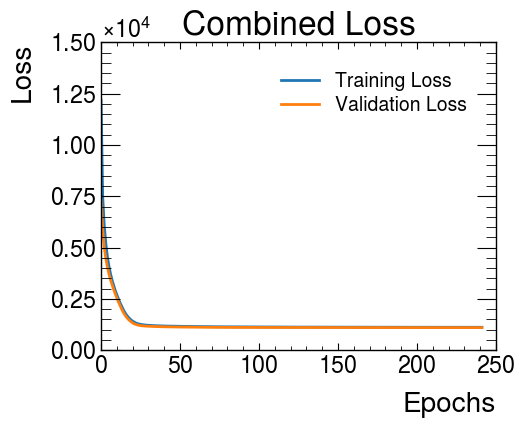

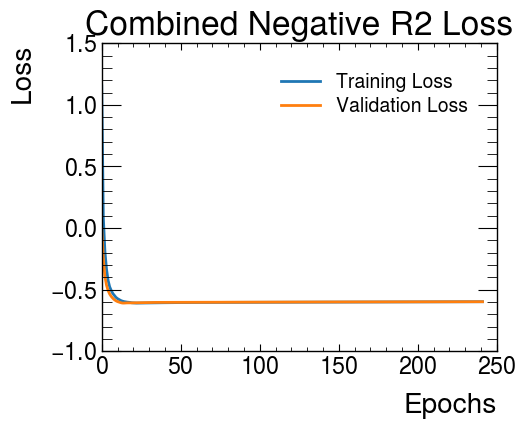

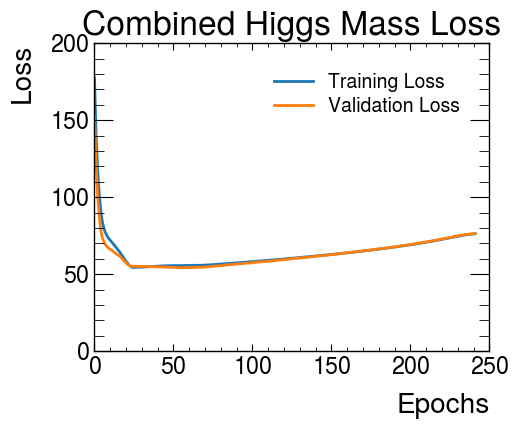

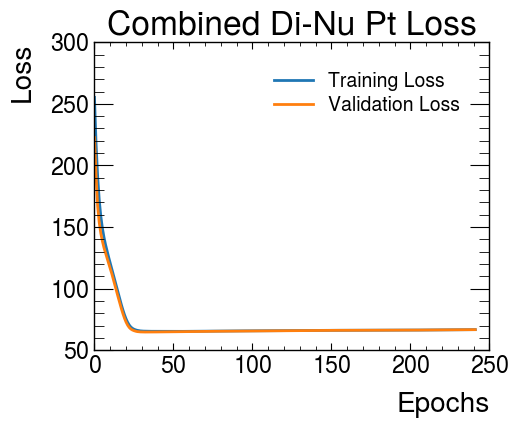

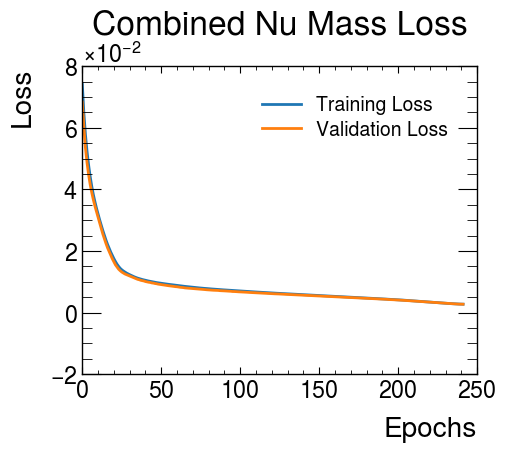

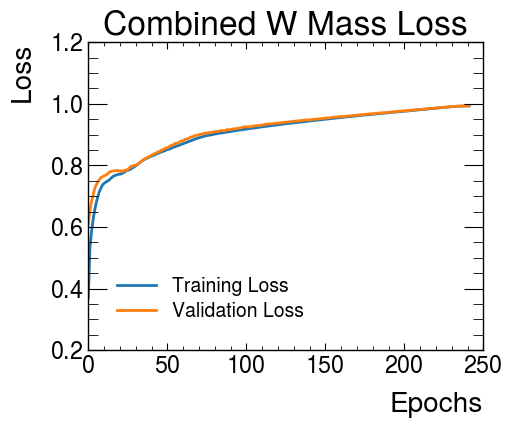

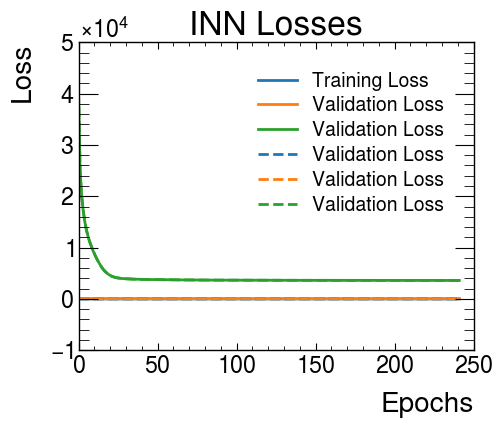

In [ ]:
# Extract loss values
loss = history.history["loss"]
val_loss = history.history["val_loss"]

neg_r2_loss = history.history["neg_r2_loss"]
val_neg_r2_loss = history.history["val_neg_r2_loss"]

higgs_mass_loss = history.history["higgs_mass_loss"]
val_higgs_mass_loss = history.history["val_higgs_mass_loss"]
dinu_pt_loss = history.history["dinu_pt_loss"]
val_dinu_pt_loss = history.history["val_dinu_pt_loss"]
nu_mass_loss = history.history["nu_mass_loss"]
val_nu_mass_loss = history.history["val_nu_mass_loss"]
w_mass_loss = history.history["w_mass_loss"]
val_w_mass_loss = history.history["val_w_mass_loss"]

L_x_loss = history.history["L_x_loss"]
L_y_loss = history.history["L_y_loss"]
L_z_loss = history.history["L_z_loss"]

############################################################################################################

# 1) Plot combined training and validation loss
plt.figure(figsize=(5, 4))
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Combined Loss")
plt.legend()
plt.grid(False)
plt.show()

# 2) Plot combined training and validation negative r2 loss
plt.figure(figsize=(5, 4))
plt.plot(neg_r2_loss, label="Training Loss")
plt.plot(val_neg_r2_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Combined Negative R2 Loss")
plt.legend()
plt.grid(False)
plt.show()

# 3) Plot combined training and validation higgs mass loss
plt.figure(figsize=(5, 4))
plt.plot(higgs_mass_loss, label="Training Loss")
plt.plot(val_higgs_mass_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Combined Higgs Mass Loss")
plt.legend()
plt.grid(False)
plt.show()

# 4) Plot combined training and validation dinu pt loss
plt.figure(figsize=(5, 4))
plt.plot(dinu_pt_loss, label="Training Loss")
plt.plot(val_dinu_pt_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Combined Di-Nu Pt Loss")
plt.legend()
plt.grid(False)
plt.show()

# 5) Plot combined training and validation nu mass loss
plt.figure(figsize=(5, 4))
plt.plot(nu_mass_loss, label="Training Loss")
plt.plot(val_nu_mass_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Combined Nu Mass Loss")
plt.legend()
plt.grid(False)
plt.show()

# 6) Plot combined training and validation w mass loss
plt.figure(figsize=(5, 4))
plt.plot(w_mass_loss, label="Training Loss")
plt.plot(val_w_mass_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Combined W Mass Loss")
plt.legend()
plt.grid(False)
plt.show()

# 7) Plot combined training and validation L_x loss
plt.figure(figsize=(5, 4))
plt.plot(L_x_loss, label="Training Loss", color="tab:blue")
plt.plot(L_y_loss, label="Validation Loss", color="tab:orange")
plt.plot(L_z_loss, label="Validation Loss", color="tab:green")
plt.plot(L_x_loss, label="Validation Loss", color="tab:blue", linestyle="--")
plt.plot(L_y_loss, label="Validation Loss", color="tab:orange", linestyle="--")
plt.plot(L_z_loss, label="Validation Loss", color="tab:green", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("INN Losses")
plt.legend()
plt.grid(False)
plt.show()

In [ ]:
# save predicted results
np.savez_compressed(
    dir_name + name + "_data.npz",
    pred_y=sig_pred.reshape(sig_truth.shape),
    test_y=sig_truth,
)
sig_pred_inv = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth_inv = np.load(dir_name + name + "_data.npz")["test_y"]

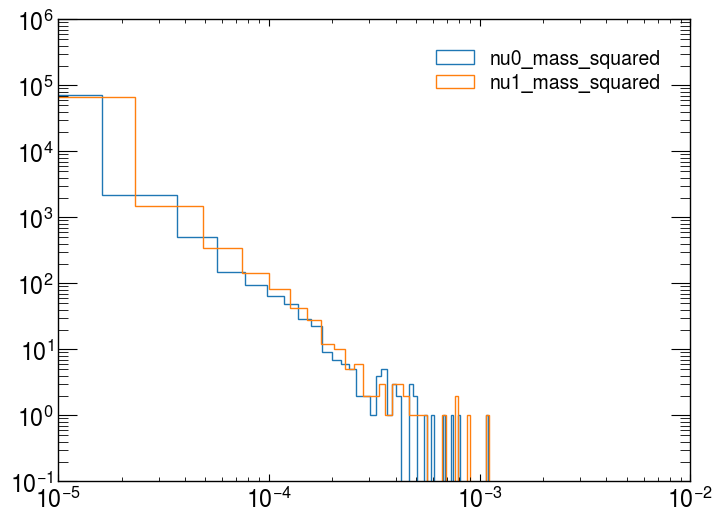

nu0_mass_squared avg: -1.6139500902393555e-08
nu1_mass_squared avg: -5.738170490092163e-08


In [ ]:
# neutrino mass checking
nu0_4vect = sig_pred_inv[:, :4] - test_x[:, :4]
nu1_4vect = sig_pred_inv[:, 4:8] - test_x[:, 4:8]
nu0_mass_squared = np.square(nu0_4vect[:, 3]) - np.square(nu0_4vect[:, 0]) - np.square(nu0_4vect[:, 1]) - np.square(nu0_4vect[:, 2])
nu1_mass_squared = np.square(nu1_4vect[:, 3]) - np.square(nu1_4vect[:, 0]) - np.square(nu1_4vect[:, 1]) - np.square(nu1_4vect[:, 2])
# nu0_mass_squared
plt.hist(nu0_mass_squared, bins=100, histtype="step", label="nu0_mass_squared")
plt.hist(nu1_mass_squared, bins=100, histtype="step", label="nu1_mass_squared")
plt.semilogx()
plt.semilogy()
plt.legend()
plt.show()

print("nu0_mass_squared avg:", np.mean(nu0_mass_squared))
print("nu1_mass_squared avg:", np.mean(nu1_mass_squared))
# plt.hist(nu1_mass_squared, bins=100, range=(0, 100), histtype="step", label="nu1_mass_squared")


True mean: 0.031, std: 39.544, min: -585.857, max: 803.254


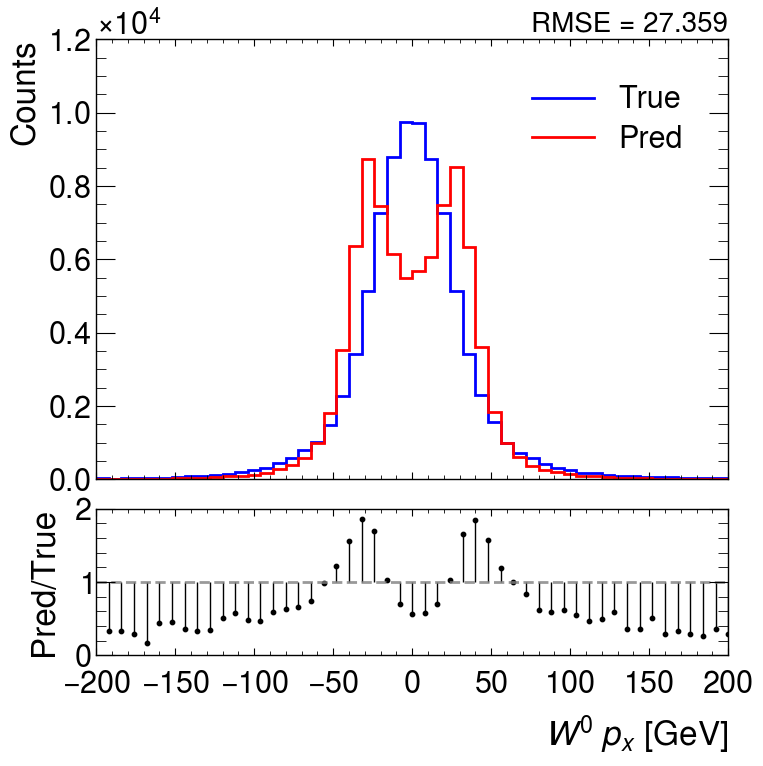

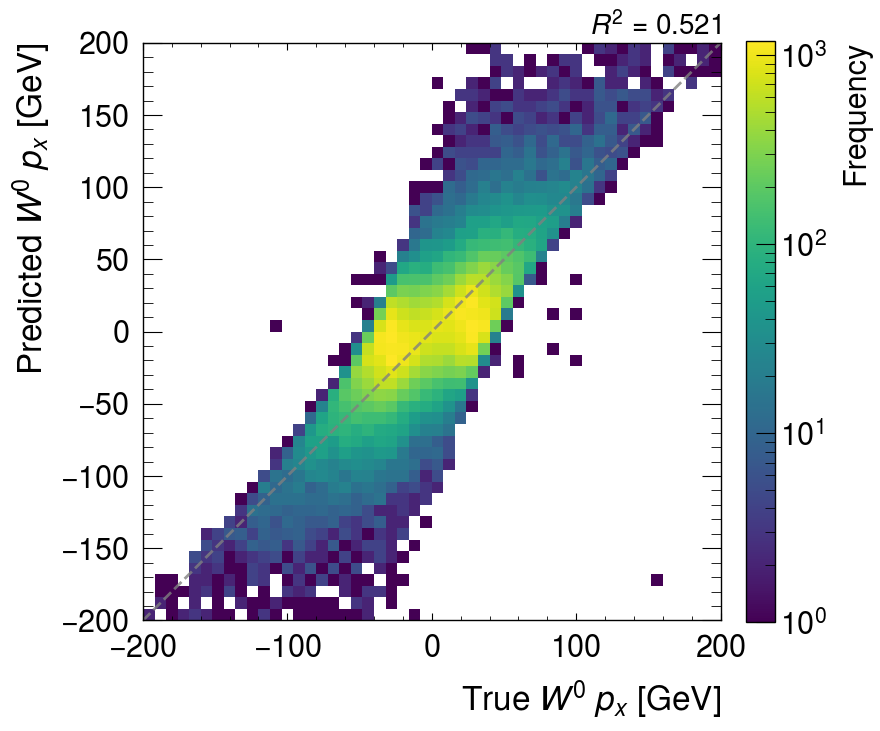

In [ ]:
print(
    f"True mean: {np.mean(sig_truth_inv[:,0]):.3f}, std: {np.std(sig_truth_inv[:,0]):.3f}, min: {np.min(sig_truth_inv[:,0]):.3f}, max: {np.max(sig_truth_inv[:,0]):.3f}"
)

set_range = [-200, 200]

plot.hist_1d(
    sig_truth_inv[:,0], sig_pred_inv[:,0],
    title=f"RMSE = {np.sqrt(mean_squared_error(sig_truth_inv[:,0], sig_pred_inv[:,0], sample_weight=None)):.3f}",
    xlabel="$W^{0}\ p_{x}$ [GeV]",
    ranges=set_range
)

plot.hist_2d(
    sig_truth_inv[:,0], sig_pred_inv[:,0],
    title=r"$R^{2}$ = " + f"{r2_score(sig_truth_inv[:,0], sig_pred_inv[:,0]):.3f}",
    xlabel="True $W^{0}\ p_{x}$ [GeV]",
    ylabel="Predicted $W^{0}\ p_{x}$ [GeV]",
    ranges=set_range
)

True mean: -0.124, std: 27.801, min: -399.814, max: 373.865


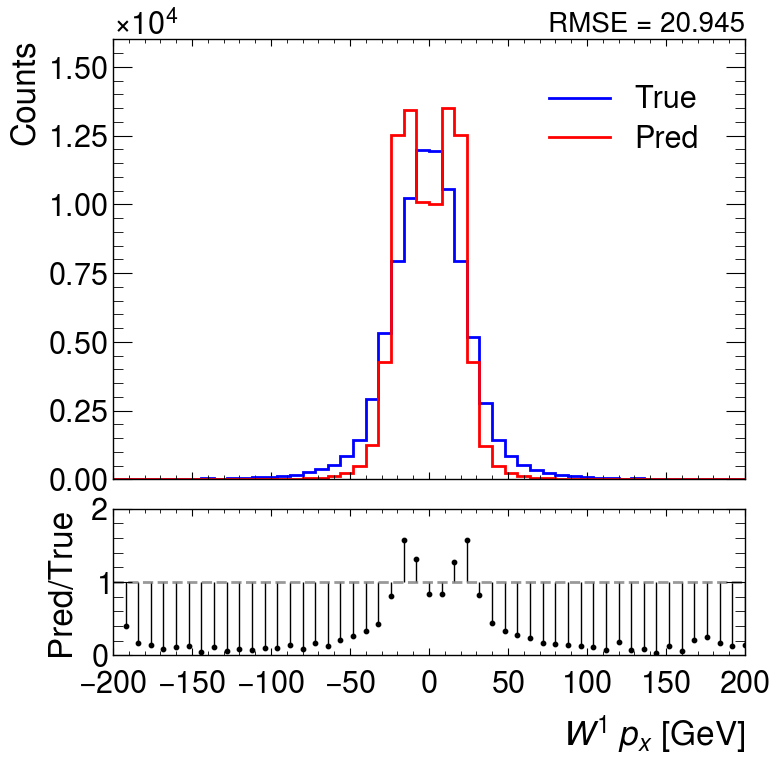

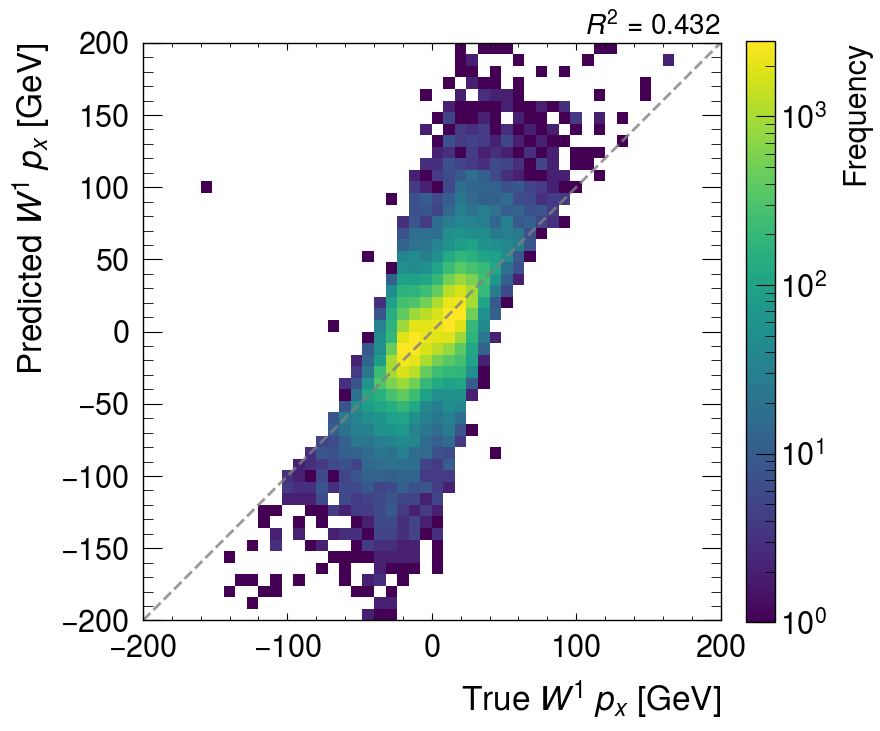

In [ ]:
print(
    f"True mean: {np.mean(sig_truth_inv[:,4]):.3f}, std: {np.std(sig_truth_inv[:,4]):.3f}, min: {np.min(sig_truth_inv[:,4]):.3f}, max: {np.max(sig_truth_inv[:,4]):.3f}"
)

set_range = [-200, 200]


plot.hist_1d(
    sig_truth_inv[:,4], sig_pred_inv[:,4],
    title=f"RMSE = {np.sqrt(mean_squared_error(sig_truth_inv[:,4], sig_pred_inv[:,4], sample_weight=None)):.3f}",
    xlabel="$W^{1}\ p_{x}$ [GeV]",
    ranges=set_range
)

plot.hist_2d(
    sig_truth_inv[:,4], sig_pred_inv[:,4],
    title=r"$R^{2}$ = " + f"{r2_score(sig_truth_inv[:,4], sig_pred_inv[:,4]):.3f}",
    xlabel="True $W^{1}\ p_{x}$ [GeV]",
    ylabel="Predicted $W^{1}\ p_{x}$ [GeV]",
    ranges=set_range
)

True mean: -0.013, std: 39.620, min: -755.579, max: 609.143


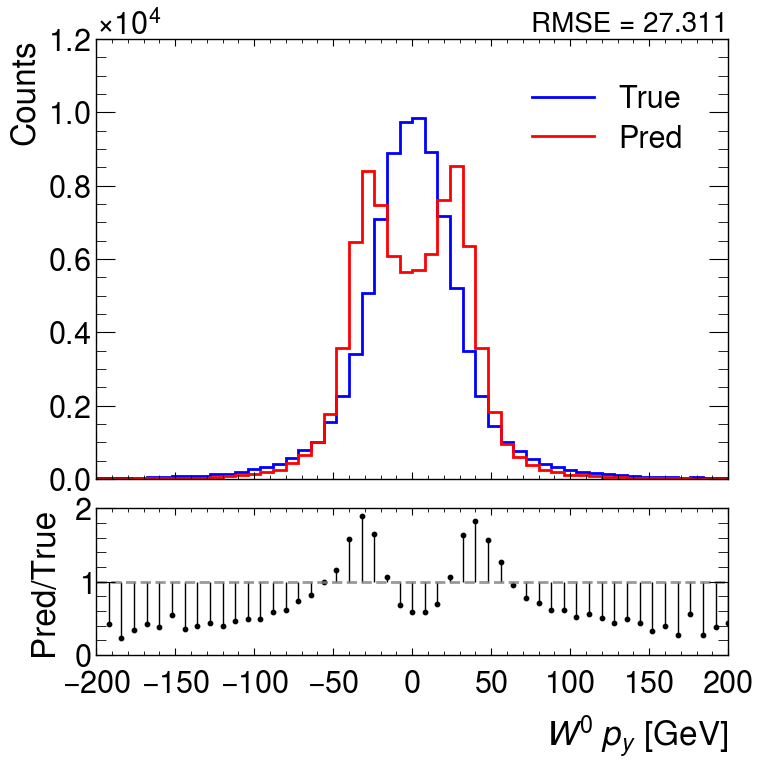

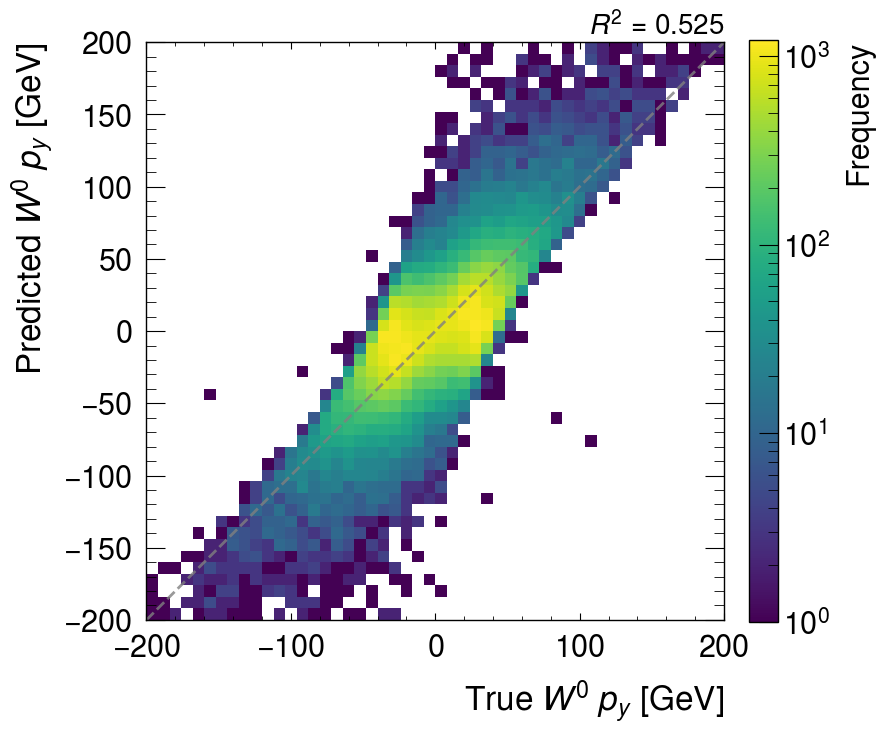

In [ ]:
print(
    f"True mean: {np.mean(sig_truth_inv[:,1]):.3f}, std: {np.std(sig_truth_inv[:,1]):.3f}, min: {np.min(sig_truth_inv[:,1]):.3f}, max: {np.max(sig_truth_inv[:,1]):.3f}"
)

set_range = [-200, 200]

plot.hist_1d(
    sig_truth_inv[:,1], sig_pred_inv[:,1],
    title=f"RMSE = {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1], sample_weight=None)):.3f}",
    xlabel="$W^{0}\ p_{y}$ [GeV]",
    ranges=set_range
)

plot.hist_2d(
    sig_truth_inv[:,1], sig_pred_inv[:,1],
    title=r"$R^{2}$ = " + f"{r2_score(sig_truth_inv[:,1], sig_pred_inv[:,1]):.3f}",
    xlabel="True $W^{0}\ p_{y}$ [GeV]",
    ylabel="Predicted $W^{0}\ p_{y}$ [GeV]",
    ranges=set_range
)

True mean: 0.031, std: 27.968, min: -417.838, max: 580.447


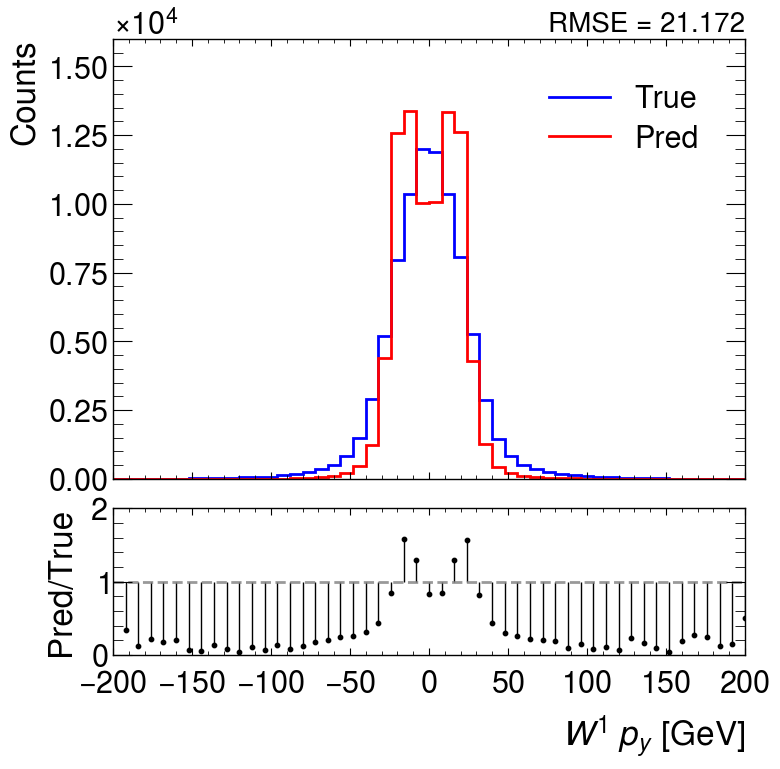

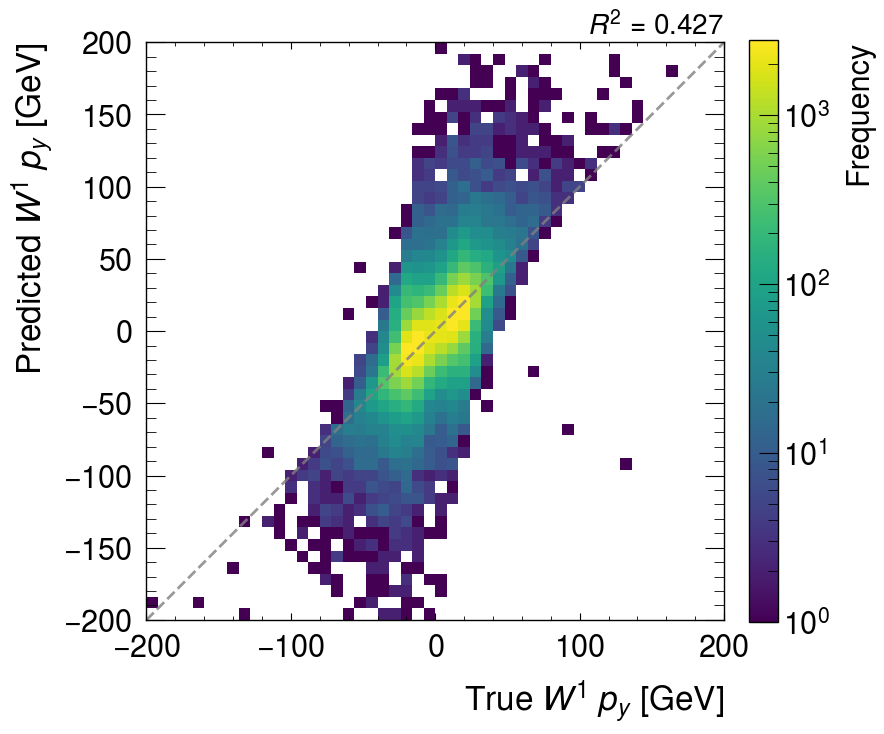

In [ ]:
print(
    f"True mean: {np.mean(sig_truth_inv[:,5]):.3f}, std: {np.std(sig_truth_inv[:,5]):.3f}, min: {np.min(sig_truth_inv[:,5]):.3f}, max: {np.max(sig_truth_inv[:,5]):.3f}"
)

set_range = [-200, 200]

plot.hist_1d(
    sig_truth_inv[:,5], sig_pred_inv[:,5],
    title=f"RMSE = {np.sqrt(mean_squared_error(sig_truth_inv[:,5], sig_pred_inv[:,5], sample_weight=None)):.3f}",
    xlabel="$W^{1}\ p_{y}$ [GeV]",
    ranges=set_range
)

plot.hist_2d(
    sig_truth_inv[:,5], sig_pred_inv[:,5],
    title=r"$R^{2}$ = " + f"{r2_score(sig_truth_inv[:,5], sig_pred_inv[:,5]):.3f}",
    xlabel="True $W^{1}\ p_{y}$ [GeV]",
    ylabel="Predicted $W^{1}\ p_{y}$ [GeV]",
    ranges=set_range
)

True mean: 0.308, std: 170.752, min: -1446.473, max: 1754.351


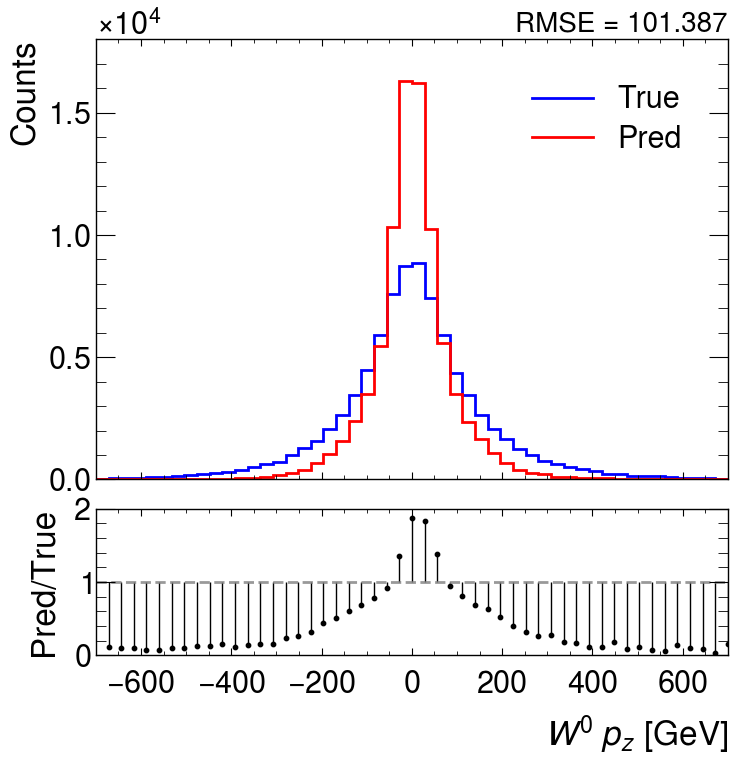

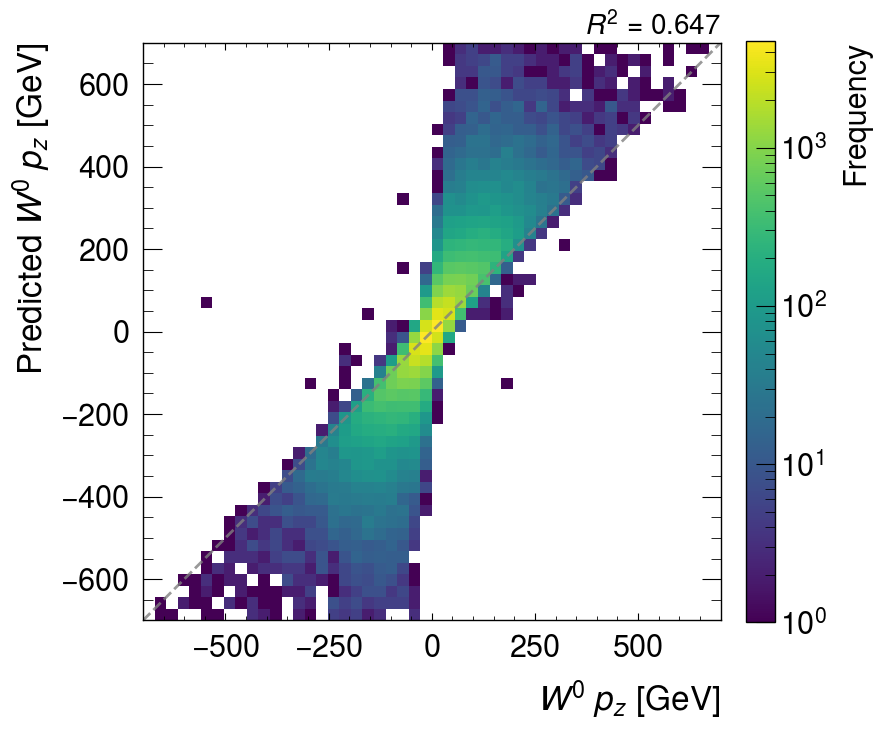

In [ ]:
print(
    f"True mean: {np.mean(sig_truth_inv[:,2]):.3f}, std: {np.std(sig_truth_inv[:,2]):.3f}, min: {np.min(sig_truth_inv[:,2]):.3f}, max: {np.max(sig_truth_inv[:,2]):.3f}"
)

set_range = [-700, 700]

plot.hist_1d(
    sig_truth_inv[:,2], sig_pred_inv[:,2],
    title=f"RMSE = {np.sqrt(mean_squared_error(sig_truth_inv[:,2], sig_pred_inv[:,2], sample_weight=None)):.3f}",
    xlabel="$W^{0}\ p_{z}$ [GeV]",
    ranges=set_range
)

plot.hist_2d(
    sig_truth_inv[:,2], sig_pred_inv[:,2],
    title=r"$R^{2}$ = " + f"{r2_score(sig_truth_inv[:,2], sig_pred_inv[:,2]):.3f}",
    xlabel="$W^{0}\ p_{z}$ [GeV]",
    ylabel="Predicted $W^{0}\ p_{z}$ [GeV]",
    ranges=set_range
)

Truth mean: -0.337, std: 110.947, min: -1170.774, max: 1427.069


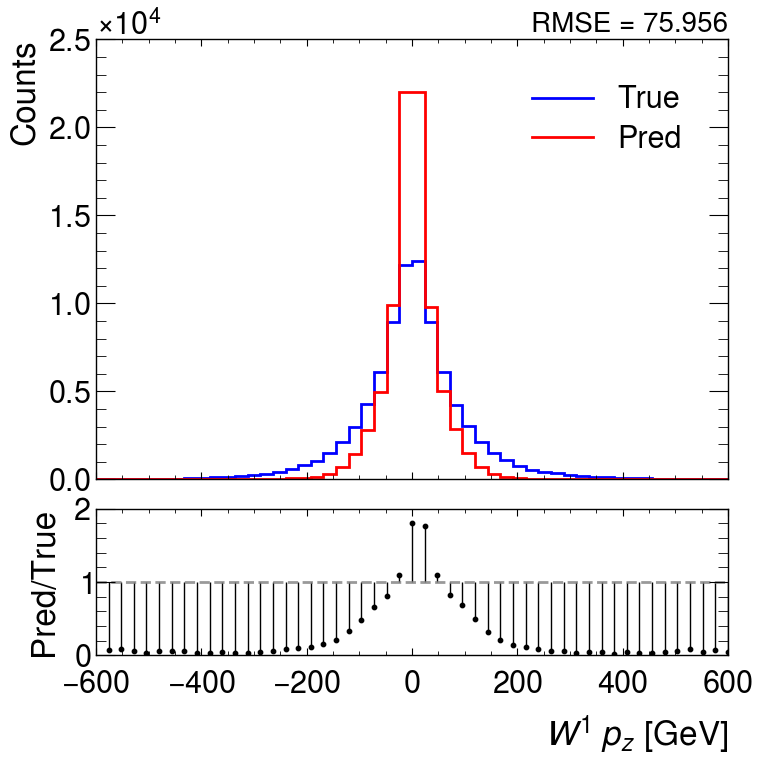

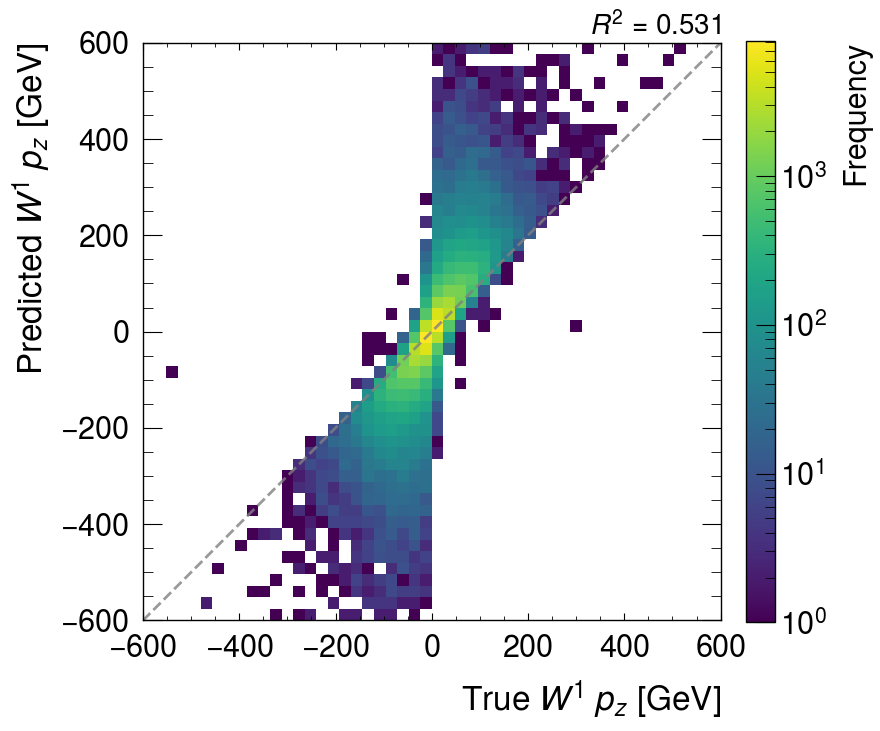

In [ ]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,6]):.3f}, std: {np.std(sig_truth_inv[:,6]):.3f}, min: {np.min(sig_truth_inv[:,6]):.3f}, max: {np.max(sig_truth_inv[:,6]):.3f}"
)

set_range = [-600, 600]

plot.hist_1d(
    sig_truth_inv[:,6], sig_pred_inv[:,6],
    title=f"RMSE = {np.sqrt(mean_squared_error(sig_truth_inv[:,6], sig_pred_inv[:,6], sample_weight=None)):.3f}",
    xlabel="$W^{1}\ p_{z}$ [GeV]",
    ranges=set_range
)

plot.hist_2d(
    sig_truth_inv[:,6], sig_pred_inv[:,6],
    title=r"$R^{2}$ = " + f"{r2_score(sig_truth_inv[:,6], sig_pred_inv[:,6]):.3f}",
    xlabel="True $W^{1}\ p_{z}$ [GeV]",
    ylabel="Predicted $W^{1}\ p_{z}$ [GeV]",
    ranges=set_range
)

True mean: 158.446, std: 111.648, min: 21.707, max: 1791.292


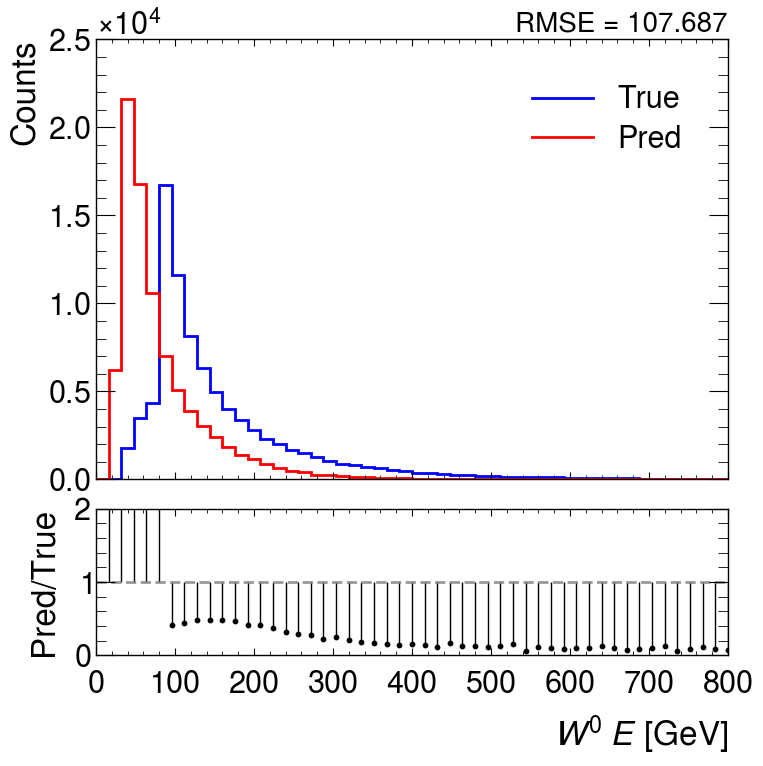

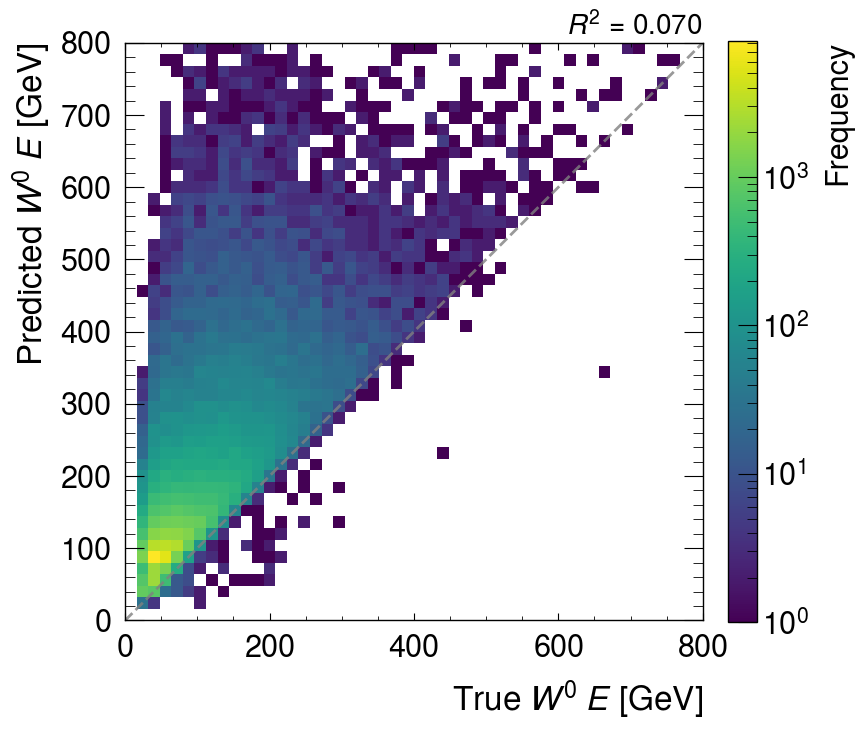

In [ ]:
print(
    f"True mean: {np.mean(sig_truth_inv[:,3]):.3f}, std: {np.std(sig_truth_inv[:,3]):.3f}, min: {np.min(sig_truth_inv[:,3]):.3f}, max: {np.max(sig_truth_inv[:,3]):.3f}"
)

set_range = [0, 800]

plot.hist_1d(
    sig_truth_inv[:,3], sig_pred_inv[:,3],
    title=f"RMSE = {np.sqrt(mean_squared_error(sig_truth_inv[:,3], sig_pred_inv[:,3], sample_weight=None)):.3f}",
    xlabel="$W^{0}\ E$ [GeV]",
    ranges=set_range
)

plot.hist_2d(
    sig_truth_inv[:,3], sig_pred_inv[:,3],
    title=r"$R^{2}$ = " + f"{r2_score(sig_truth_inv[:,3], sig_pred_inv[:,3]):.3f}",
    xlabel="True $W^{0}\ E$ [GeV]",
    ylabel="Predicted $W^{0}\ E$ [GeV]",
    ranges=set_range
)

True mean: 98.991, std: 77.608, min: 17.001, max: 1443.825


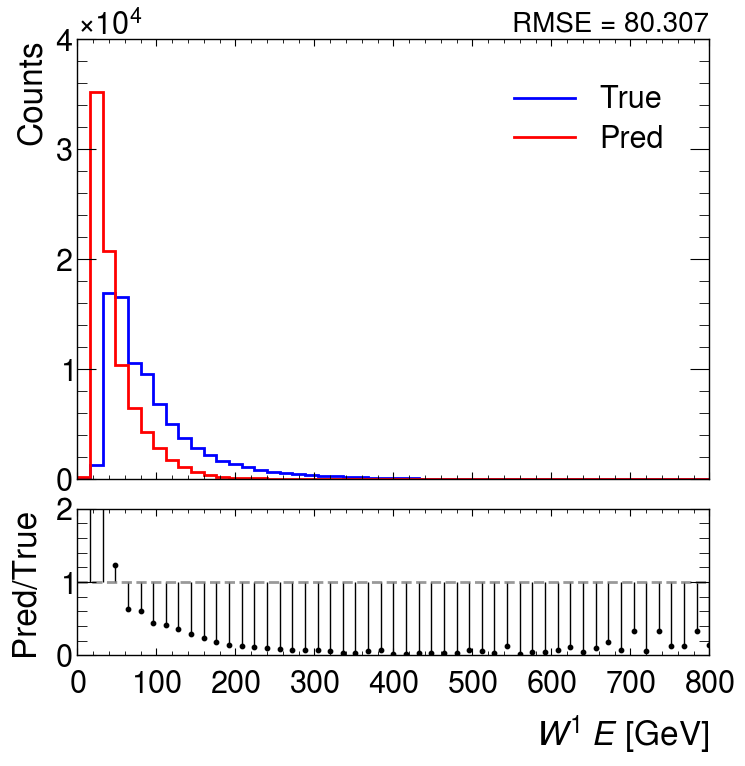

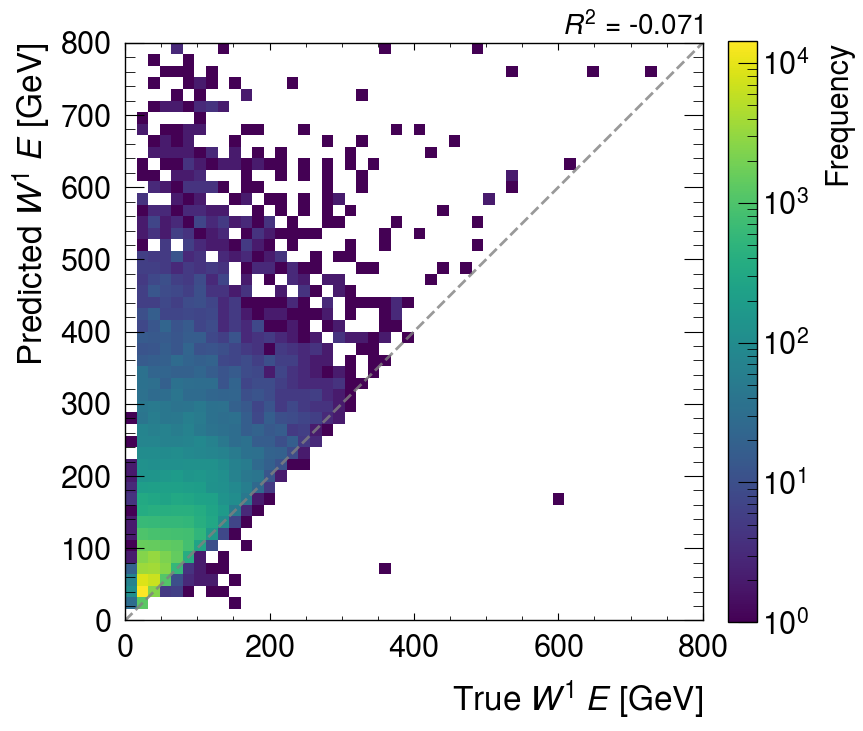

In [ ]:
print(
    f"True mean: {np.mean(sig_truth_inv[:,7]):.3f}, std: {np.std(sig_truth_inv[:,7]):.3f}, min: {np.min(sig_truth_inv[:,7]):.3f}, max: {np.max(sig_truth_inv[:,7]):.3f}"
)

set_range = [0, 800]

plot.hist_1d(
    sig_truth_inv[:,7], sig_pred_inv[:,7],
    title=f"RMSE = {np.sqrt(mean_squared_error(sig_truth_inv[:,7], sig_pred_inv[:,7], sample_weight=None)):.3f}",
    xlabel="$W^{1}\ E$ [GeV]",
    ranges=set_range
)

plot.hist_2d(
    sig_truth_inv[:,7], sig_pred_inv[:,7],
    title=r"$R^{2}$ = " + f"{r2_score(sig_truth_inv[:,7], sig_pred_inv[:,7]):.3f}",
    xlabel="True $W^{1}\ E$ [GeV]",
    ylabel="Predicted $W^{1}\ E$ [GeV]",
    ranges=set_range
)

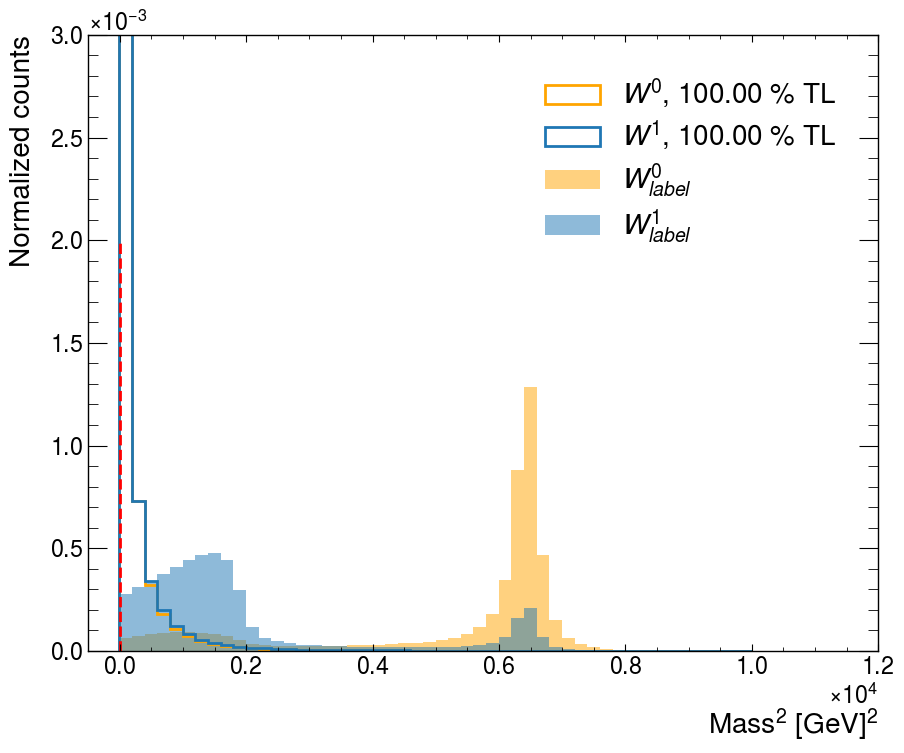

m2 with 100.00 % time-like (TL) evts


In [ ]:
lead_time_like = np.square(sig_pred_inv[:, 3]) - np.sum(
    np.square(sig_pred_inv[:, 0:3]), axis=1
)
lead_time_mask = (lead_time_like > 0) * 1
sublead_time_like = np.square(sig_pred_inv[:, 7]) - np.sum(
    np.square(sig_pred_inv[:, 4:7]), axis=1
)
sublead_time_mask = (sublead_time_like > 0) * 1

bin_edges = np.linspace(-5, 1.0e4, 51)
figure = plt.figure(figsize=(10, 8))
plt.hist(
    lead_time_like,
    bins=bin_edges,
    fill=False,
    color="orange",
    histtype="step",
    label=r"$W^{0}$, "
    + f"{100 * np.sum(lead_time_mask) / len(lead_time_mask):.2f} % TL",
    density=True,
    weights=None,
    linewidth=2,
)
plt.hist(
    sublead_time_like,
    bins=bin_edges,
    fill=False,
    color="tab:blue",
    histtype="step",
    label=r"$W^{1}$, "
    + f"{100 * np.sum(sublead_time_mask) / len(sublead_time_mask):.2f} % TL",
    density=True,
    weights=None,
    linewidth=2,
)
plt.hist(
    np.square(w_lead.m),
    bins=bin_edges,
    color="orange",
    fill=True,
    histtype="bar",
    alpha=0.5,
    label=r"$W_{label}^{0}$",
    density=True,
    # weights=mc_weight,
)
plt.hist(
    np.square(w_sublead.m),
    bins=bin_edges,
    color="tab:blue",
    fill=True,
    histtype="bar",
    alpha=0.5,
    label=r"$W_{label}^{1}$",
    density=True,
    # weights=mc_weight,
)
plt.vlines(0, 0, 2e-3, color="red", linestyle="--")
plt.xlim(-5e2, 1.2e4)
plt.ylim(0, 3e-3)
plt.xlabel(r"Mass$^{2}$ [GeV]$^{2}$", labelpad=20)
plt.ylabel("Normalized counts")
plt.legend(loc="upper right", prop={'size': 20})  # Adjust the size value as needed
plt.show()
print(f"m2 with {100 * np.sum(lead_time_mask * sublead_time_mask) / len(lead_time_mask):.2f} % time-like (TL) evts")

Truth mean: 3615.291, std: 2594.373, min: 4.010, max: 11077.988


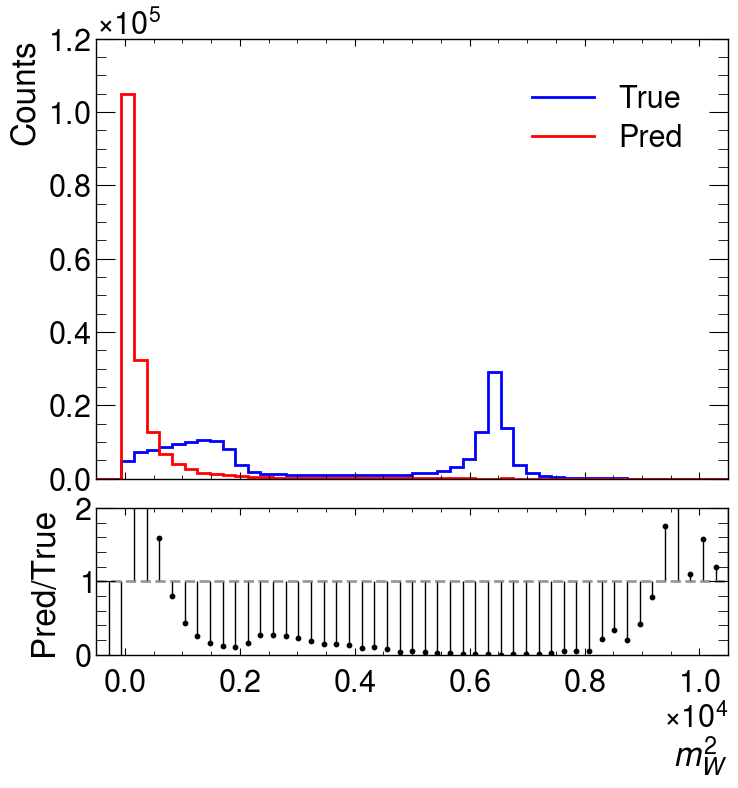

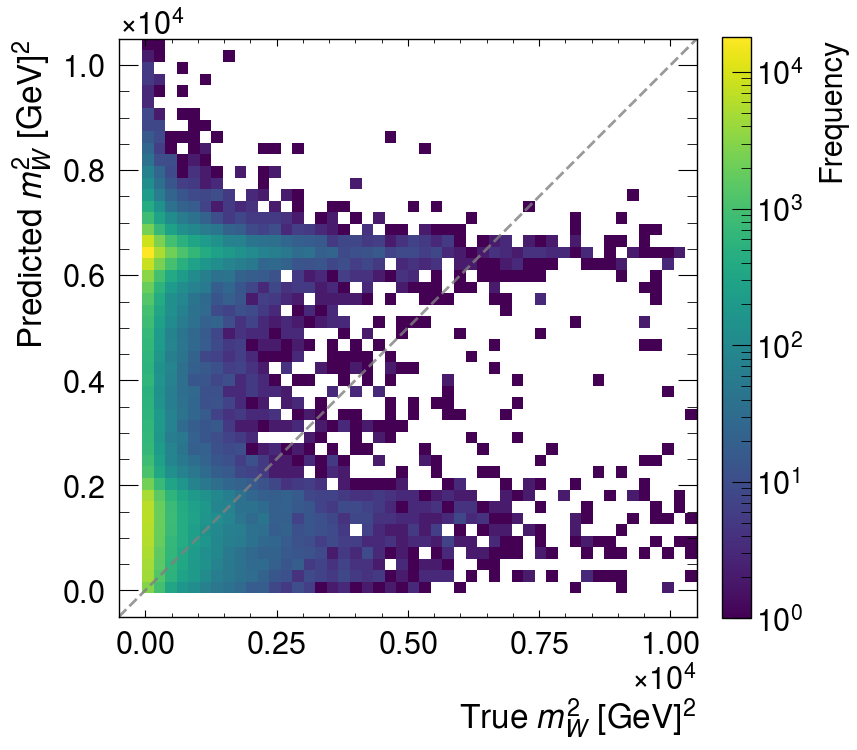

In [ ]:
# TODO: 2d mass squared
pred_m2 = np.concatenate([lead_time_like, sublead_time_like], axis=-1)
truth_m2 = np.concatenate(
    [np.square(w_lead.m)[test_indices], np.square(w_sublead.m)[test_indices]], axis=-1
)

print(
    f"Truth mean: {np.mean(truth_m2):.3f}, std: {np.std(truth_m2):.3f}, min: {np.min(truth_m2):.3f}, max: {np.max(truth_m2):.3f}"
)

set_range = [-500, 10_500]


plot.hist_1d(
    truth_m2, pred_m2,
    title="",
    xlabel=r"$m_{W}^{2}$",
    xpad=25,
    ranges=set_range
)

plot.hist_2d(
    truth_m2, pred_m2,
    title="",
    xlabel="True $m_{W}^{2}$ [GeV]$^2$",
    ylabel="Predicted $m_{W}^{2}$ [GeV]$^2$",
    xpad=25,
    ranges=set_range
)

In [ ]:

# TODO: CGLMP

def Bij(particles):
    # Ensure ROOT is properly initialized
    ROOT.gROOT.SetBatch(True)

    def cglmp(z_xp, z_xn, z_yp, z_yn):
        """
        This is a function to calculate Bij (CGLMP values).
        :param z_xp: Angle (xi) between positive lepton and x-axis.
        :param z_xn: Angle (xi) between negative lepton and x-axis.
        :param z_yp: Angle (xi) between positive lepton and y-axis.
        :param z_xn: Angle (xi) between negative lepton and y-axis.
        """
        # count expectation value, use (27) in Alan's paper
        tr_a = (np.divide(8, np.sqrt(3))) * (z_xp * z_xn + z_yp * z_yn)
        tr_b = (
            25
            * (np.square(z_xp) - np.square(z_yp))
            * (np.square(z_xn) - np.square(z_yn))
        )
        tr_c = 100 * (z_xp * z_yp * z_xn * z_yn)
        tr = tr_a + tr_b + tr_c

        return tr

    WpBoson = TLorentzVector(*particles[:4])
    WpLepton = TLorentzVector(*particles[4:8])
    WnBoson = TLorentzVector(*particles[8:12])
    WnLepton = TLorentzVector(*particles[12:16])

    # construct Higgs 4-vector
    Higgs = WpBoson + WnBoson

    # construct a moving orthogonal basis (k,r,n)
    Beam_p = TLorentzVector(0, 0, 1, 1)  # spatial-axis

    # define boost vector
    Higgsb = Higgs.BoostVector()

    # (1) performs a boost transformation from the rod frame to the rawal one.
    # Perform boost transformation from the rod frame to the rawal one
    for vec in [WpBoson, WpLepton, WnBoson, WnLepton, Beam_p]:
        vec.Boost(-Higgsb)

    # 2. Define (k,r,n) -> definitions are in Alan's paper
    k_per = TVector3(WpBoson.X(), WpBoson.Y(), WpBoson.Z())
    p_per = TVector3(Beam_p.X(), Beam_p.Y(), Beam_p.Z())  # in the Higgs rest frame
    k = k_per.Unit()  # normalized -> unit vector
    p = p_per.Unit()
    y = p.Dot(k)
    r_length = np.sqrt(1 - y * y)
    r = (1 / r_length) * (p - y * k)
    n = (1 / r_length) * (p.Cross(k))  # (1/sin)*sin = 1 -> unit vector

    # 3. Further boost to W+ and W- frame respectively
    WpkBoost = WpBoson.BoostVector()
    WpBoson.Boost(-WpkBoost)
    WpLepton.Boost(-WpkBoost)
    WnkBoost = WnBoson.BoostVector()
    WnBoson.Boost(-WnkBoost)
    WnLepton.Boost(-WnkBoost)

    # 4. Map all particle to (k,r,n) frame
    WpLp = WpLepton.Vect()  # momentum in (k,r,n)
    WnLp = WnLepton.Vect()
    # Mapping to n-r-k basis
    WpLp_k = TLorentzVector(WpLp.Dot(n), WpLp.Dot(r), WpLp.Dot(k), WpLepton.E())
    WnLp_k = TLorentzVector(WnLp.Dot(n), WnLp.Dot(r), WnLp.Dot(k), WnLepton.E())

    # 5. Calculate directional cosines
    # directional cosine from Wp
    WpLp_Vect_Mag = WpLp_k.Vect().Mag()
    cos_n_join_p = np.divide(WpLp_k.X(), WpLp_Vect_Mag)
    cos_r_join_p = np.divide(WpLp_k.Y(), WpLp_Vect_Mag)
    cos_k_join_p = np.divide(WpLp_k.Z(), WpLp_Vect_Mag)
    # directional cosine from Wn
    WnLp_Vect_Mag = WnLp_k.Vect().Mag()
    cos_n_join_n = np.divide(WnLp_k.X(), WnLp_Vect_Mag)
    cos_r_join_n = np.divide(WnLp_k.Y(), WnLp_Vect_Mag)
    cos_k_join_n = np.divide(WnLp_k.Z(), WnLp_Vect_Mag)

    # 6. Calculate Bij (CGLMP values)
    B_xy = cglmp(cos_n_join_p, cos_n_join_n, cos_r_join_p, cos_r_join_n)
    B_yz = cglmp(cos_r_join_p, cos_r_join_n, cos_k_join_p, cos_k_join_n)
    B_zx = cglmp(cos_n_join_p, cos_n_join_n, cos_k_join_p, cos_k_join_n)

    return (
        np.array([B_xy, B_yz, B_zx]),
        np.array([cos_n_join_p, cos_r_join_p, cos_k_join_p]),
        np.array([cos_n_join_n, cos_r_join_n, cos_k_join_n]),
    )
    
def result_generator(particles):
    with multiprocessing.Pool(WORKERS) as pool:
        # Retrieve the output from the pool
        results = list(pool.map(Bij, particles))
    
    # Unpack the results
    bij, xi_p, xi_n = zip(*results)
    
    bij = np.vstack(bij)  # Flatten the nested array
    xi_p = np.vstack(xi_p)
    xi_n = np.vstack(xi_n)
    mask = np.any(np.isnan(bij), axis=1)
    return (
        bij[~mask, :],
        xi_p[~mask, :],
        xi_n[~mask, :],
    )

In [ ]:
# reco
particles = np.concatenate(
    [
        sig_pred_inv[:, 0:4],
        lead_lep_p4[test_indices],
        sig_pred_inv[:, 4:8],
        sublead_lep_p4[test_indices],
    ],
    axis=1,
)
bij = result_generator(particles)[0][0:80_000,:]
xi_p = result_generator(particles)[1][0:80_000,:]
xi_n = result_generator(particles)[2][0:80_000,:]

# truth
particles = np.concatenate(
    [
        sig_truth_inv[:, 0:4],
        truth_lead_lep_p4[test_indices],
        sig_truth_inv[:, 4:8],
        truth_sublead_lep_p4[test_indices],
    ],
    axis=1,
)
truth_bij = result_generator(particles)[0][0:80_000,:]
truth_xi_p = result_generator(particles)[1][0:80_000,:]
truth_xi_n = result_generator(particles)[2][0:80_000,:]

True mean     : 2.468, std: 12.019, min: -25.100, max: 29.607
Predicted mean: 3.410, std: 3.316, min: -0.097, max: 23.289


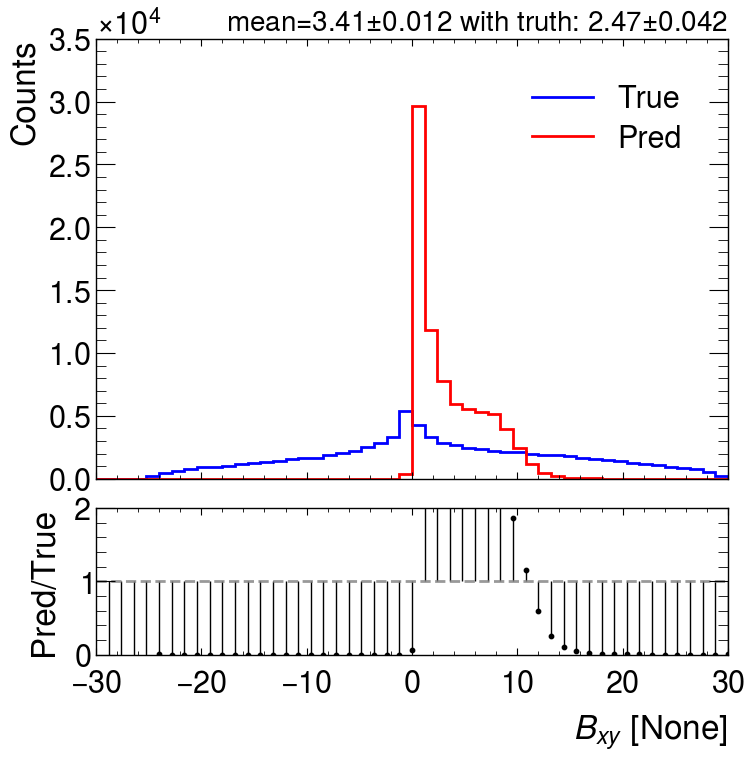

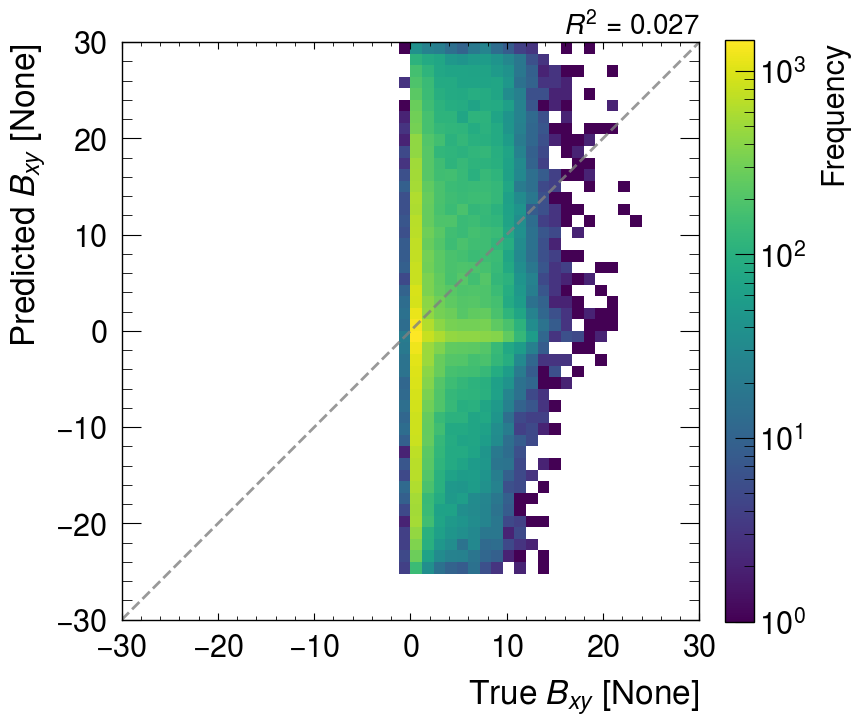

In [ ]:

print(
    f"True mean     : {np.mean(truth_bij[:,0]):.3f}, std: {np.std(truth_bij[:,0]):.3f}, min: {np.min(truth_bij[:,0]):.3f}, max: {np.max(truth_bij[:,0]):.3f}"
)
print(
    f"Predicted mean: {np.mean(bij[:,0]):.3f}, std: {np.std(bij[:,0]):.3f}, min: {np.min(bij[:,0]):.3f}, max: {np.max(bij[:,0]):.3f}"
)

set_range = [-30, 30]

plot.hist_1d(
    truth_bij[:,0], bij[:,0],
    title=rf"mean={np.mean(bij[:,0]):.2f}$\pm${sp.stats.sem(bij[:,0]):.3f}"
    + f" with truth: {np.mean(truth_bij[:,0]):.2f}$\pm${sp.stats.sem(truth_bij[:,0]):.3f}",
    xlabel=r"$B_{xy}$ [None]",
    ranges=set_range
)

plot.hist_2d(
    truth_bij[:,0], bij[:,0],
    title=r"$R^{2}$ = " + f"{r2_score(truth_bij[:,0], bij[:,0]):.3f}",
    xlabel="True $B_{{xy}}$ [None]",
    ylabel="Predicted $B_{{xy}}$ [None]",
    ranges=set_range
)

True mean     : 2.060, std: 8.727, min: -25.095, max: 29.572
Predicted mean: -2.158, std: 14.067, min: -25.106, max: 28.730


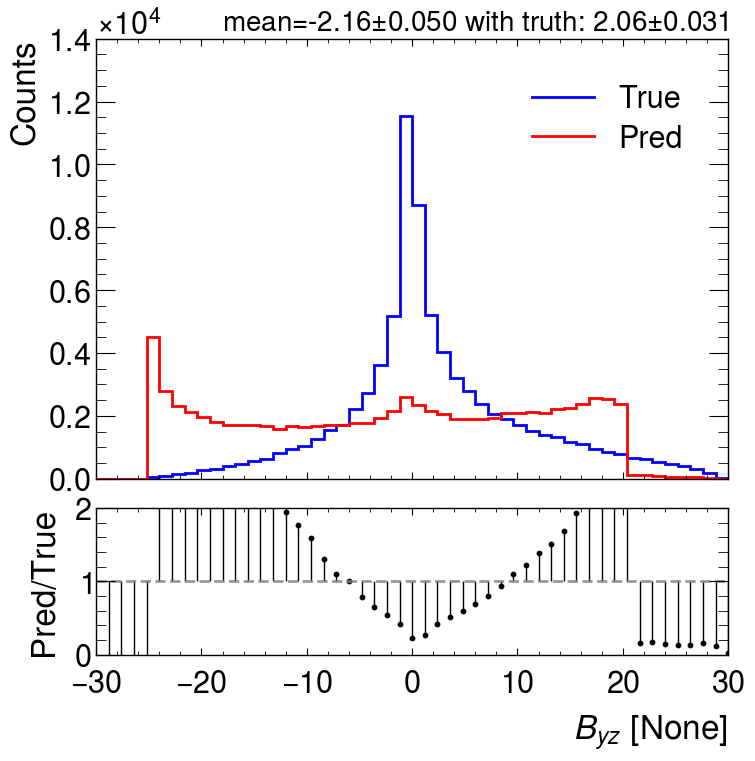

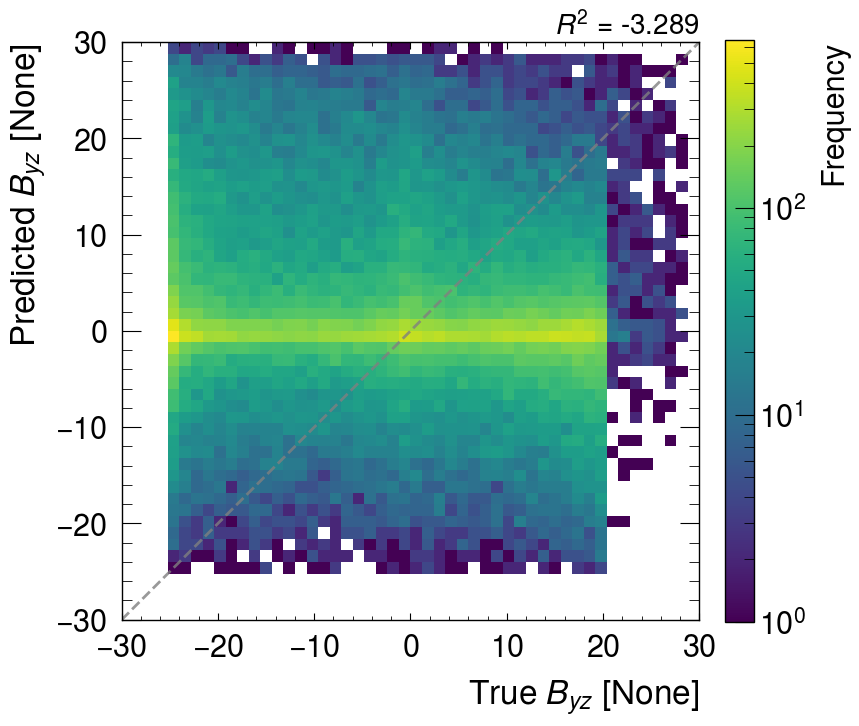

In [ ]:

print(
    f"True mean     : {np.mean(truth_bij[:,1]):.3f}, std: {np.std(truth_bij[:,1]):.3f}, min: {np.min(truth_bij[:,1]):.3f}, max: {np.max(truth_bij[:,1]):.3f}"
)
print(
    f"Predicted mean: {np.mean(bij[:,1]):.3f}, std: {np.std(bij[:,1]):.3f}, min: {np.min(bij[:,1]):.3f}, max: {np.max(bij[:,1]):.3f}"
)

set_range = [-30, 30]


plot.hist_1d(
    truth_bij[:,1], bij[:,1],
    title=fr"mean={np.mean(bij[:,1]):.2f}$\pm${sp.stats.sem(bij[:,1]):.3f}"
    + f" with truth: {np.mean(truth_bij[:,1]):.2f}$\pm${sp.stats.sem(truth_bij[:,1]):.3f}",
    xlabel=r"$B_{yz}$ [None]",
    ranges=set_range
)

plot.hist_2d(
    truth_bij[:,1], bij[:,1],
    title=r"$R^{2}$ = " + f"{r2_score(truth_bij[:,1], bij[:,1]):.3f}",
    xlabel="True $B_{{yz}}$ [None]",
    ylabel="Predicted $B_{{yz}}$ [None]",
    ranges=set_range
)

True mean     : 3.228, std: 10.739, min: -25.073, max: 29.599
Predicted mean: 5.050, std: 10.371, min: -25.106, max: 28.778


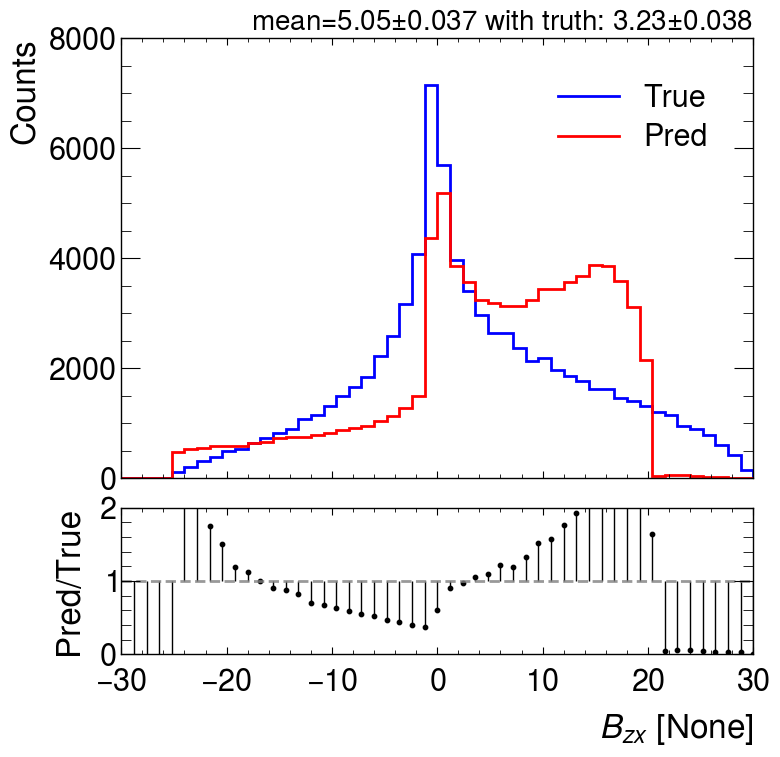

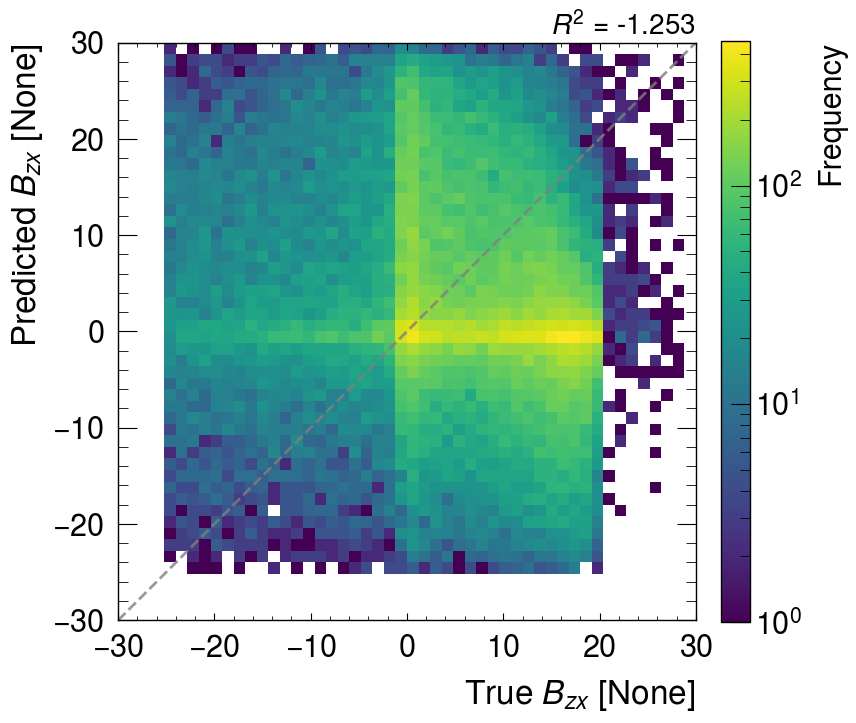

In [ ]:

print(
    f"True mean     : {np.mean(truth_bij[:,2]):.3f}, std: {np.std(truth_bij[:,2]):.3f}, min: {np.min(truth_bij[:,2]):.3f}, max: {np.max(truth_bij[:,2]):.3f}"
)
print(
    f"Predicted mean: {np.mean(bij[:,2]):.3f}, std: {np.std(bij[:,2]):.3f}, min: {np.min(bij[:,2]):.3f}, max: {np.max(bij[:,2]):.3f}"
)

set_range = [-30, 30]

plot.hist_1d(
    truth_bij[:,2], bij[:,2],
    title=rf"mean={np.mean(bij[:,2]):.2f}$\pm${sp.stats.sem(bij[:,2]):.3f}"
    + rf" with truth: {np.mean(truth_bij[:,2]):.2f}$\pm${sp.stats.sem(truth_bij[:,2]):.3f}",
    xlabel=r"$B_{zx}$ [None]",
    ranges=set_range
)

plot.hist_2d(
    truth_bij[:,2], bij[:,2],
    title=r"$R^{2}$ = " + f"{r2_score(truth_bij[:,2], bij[:,2]):.3f}",
    xlabel=r"True $B_{{zx}}$ [None]",
    ylabel=r"Predicted $B_{{zx}}$ [None]",
    ranges=set_range
)

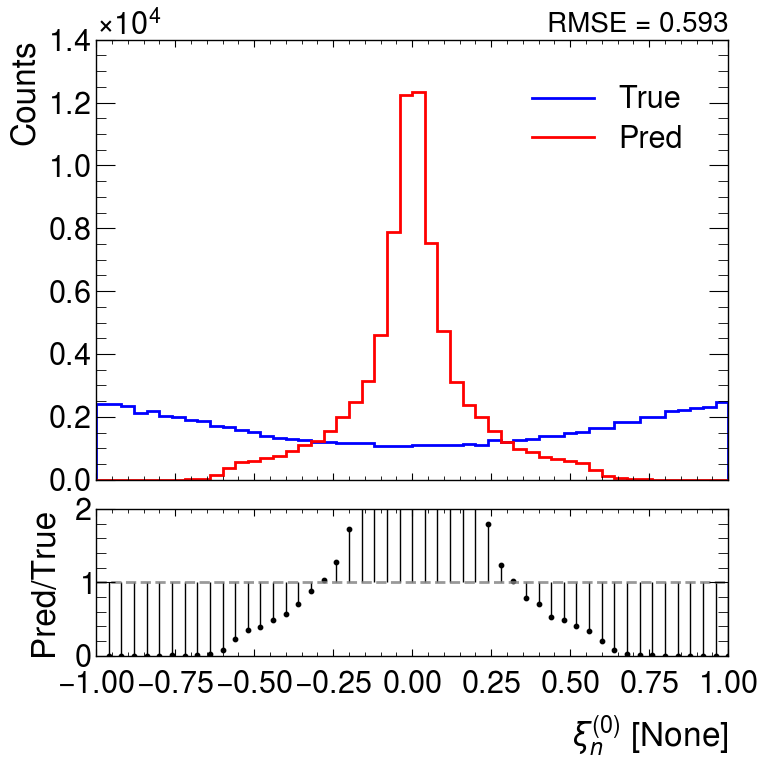

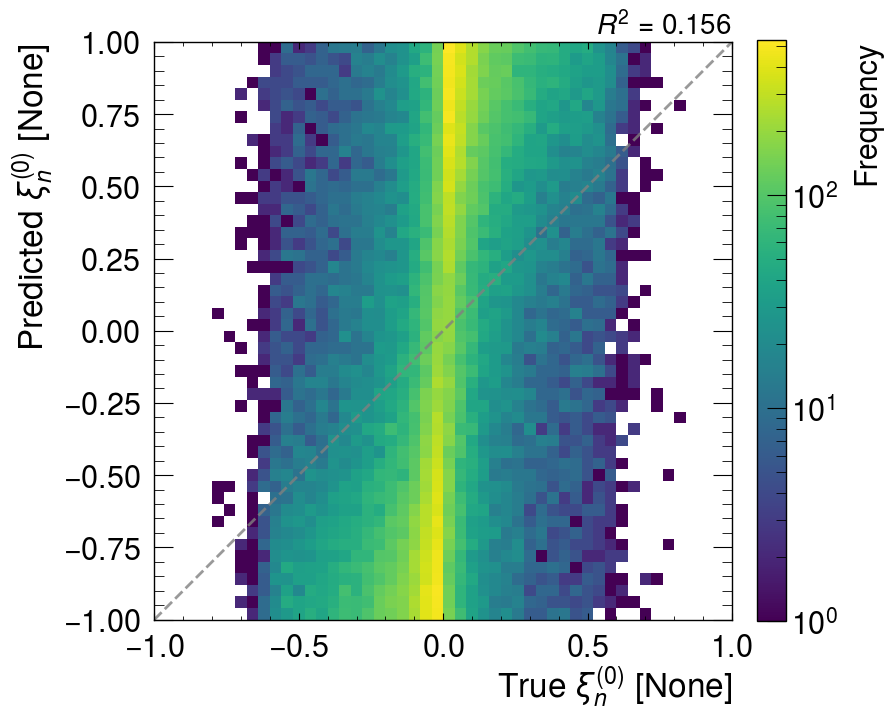

In [ ]:
set_range = [-1, 1]


plot.hist_1d(
    truth_xi_p[:,0], xi_p[:,0],
    title=f"RMSE = {np.sqrt(mean_squared_error(truth_xi_p[:,0], xi_p[:,0], sample_weight=None)):.3f}",
    xlabel=r"$\xi^{(0)}_{n}$ [None]",
    ranges=set_range
)

plot.hist_2d(
    truth_xi_p[:,0], xi_p[:,0],
    title=r"$R^{2}$ = " + f"{r2_score(truth_xi_p[:,0], xi_p[:,0]):.3f}",
    xlabel=r"True $\xi^{(0)}_{n}$ [None]",
    ylabel=r"Predicted $\xi^{(0)}_{n}$ [None]",
    xpad=0,
    ranges=set_range
)

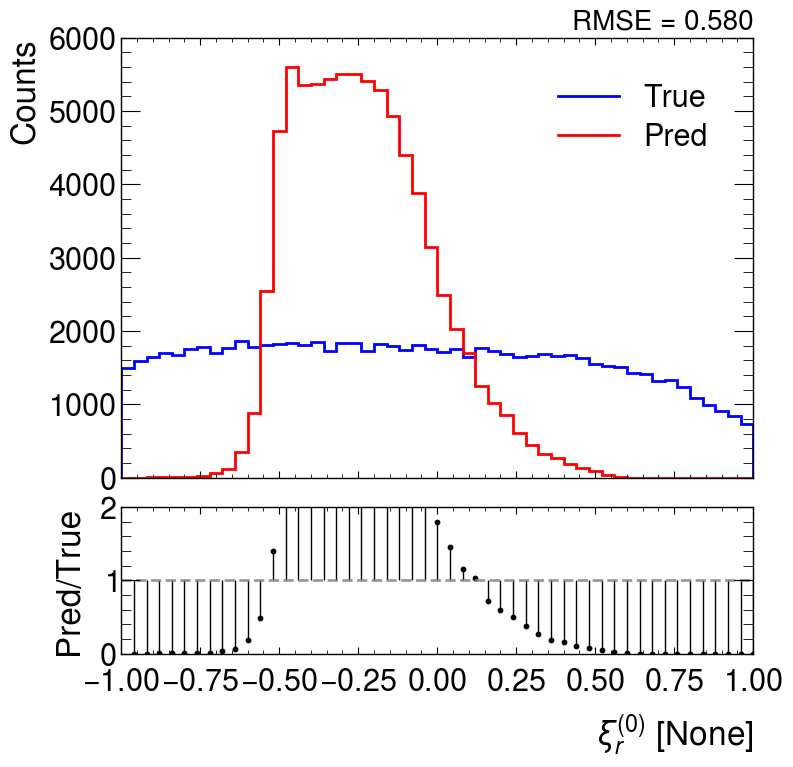

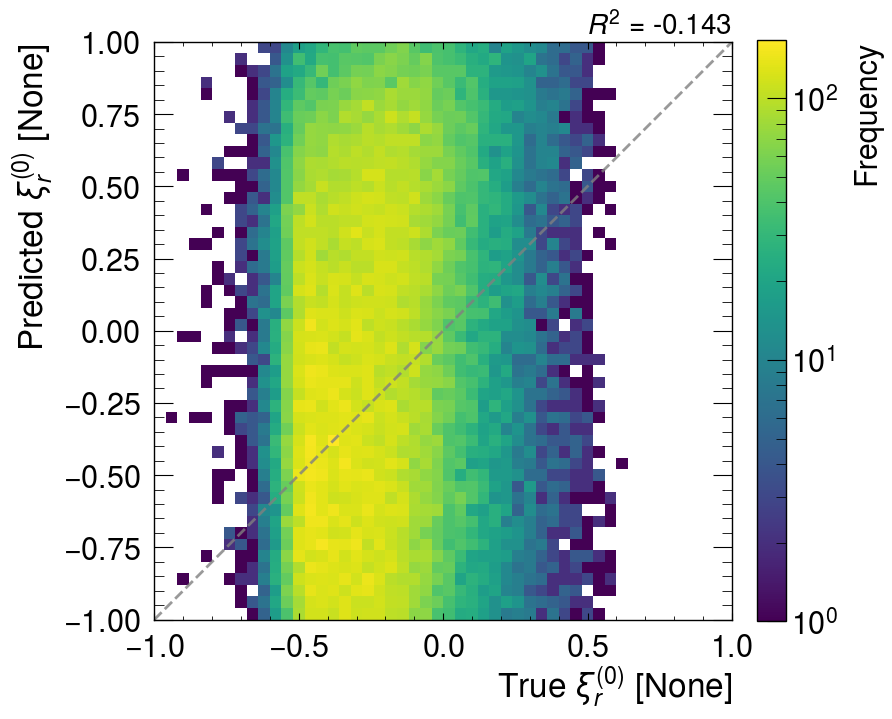

In [ ]:
set_range = [-1, 1]

plot.hist_1d(
    truth_xi_p[:,1], xi_p[:,1],
    title=f"RMSE = {np.sqrt(mean_squared_error(truth_xi_p[:,1], xi_p[:,1], sample_weight=None)):.3f}",
    xlabel=r"$\xi^{(0)}_{r}$ [None]",
    ranges=set_range
)

plot.hist_2d(
    truth_xi_p[:,1], xi_p[:,1],
    title=r"$R^{2}$ = " + f"{r2_score(truth_xi_p[:,1], xi_p[:,1]):.3f}",
    xlabel=r"True $\xi^{(0)}_{r}$ [None]",
    ylabel=r"Predicted $\xi^{(0)}_{r}$ [None]",
    xpad=0,
    ranges=set_range
)

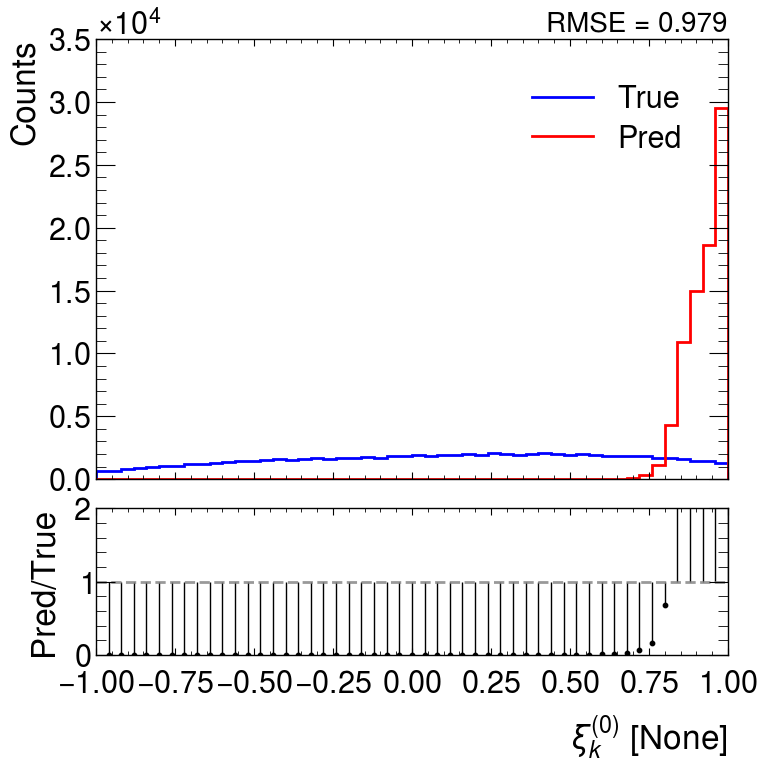

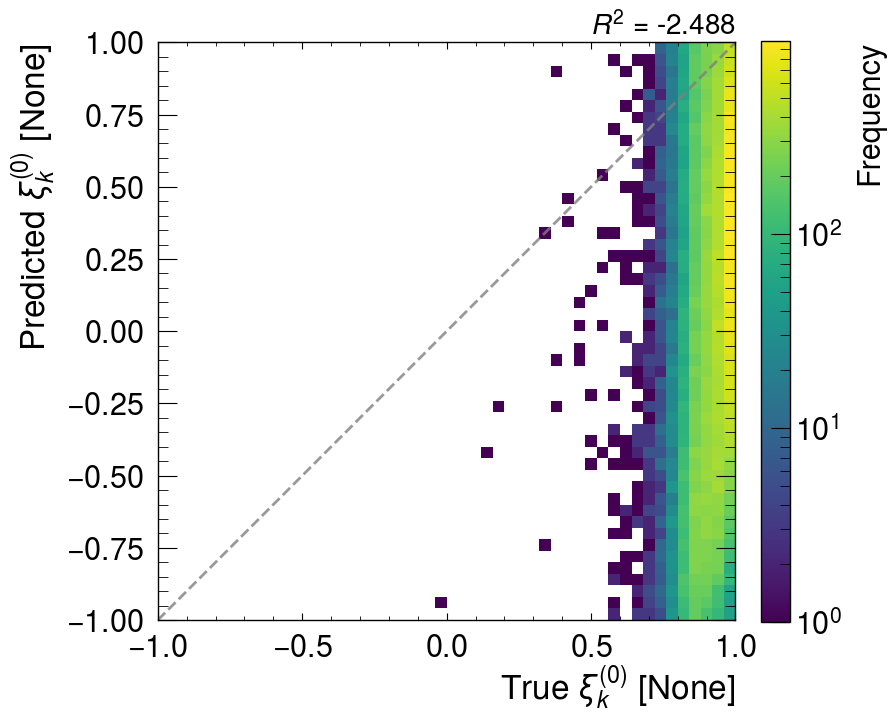

In [ ]:
set_range = [-1, 1]

plot.hist_1d(
    truth_xi_p[:,2], xi_p[:,2],
    title=f"RMSE = {np.sqrt(mean_squared_error(truth_xi_p[:,2], xi_p[:,2], sample_weight=None)):.3f}",
    xlabel=r"$\xi^{(0)}_{k}$ [None]",
    ranges=set_range
)

plot.hist_2d(
    truth_xi_p[:,2], xi_p[:,2],
    title=r"$R^{2}$ = " + f"{r2_score(truth_xi_p[:,2], xi_p[:,2]):.3f}",
    xlabel=r"True $\xi^{(0)}_{k}$ [None]",
    ylabel=r"Predicted $\xi^{(0)}_{k}$ [None]",
    xpad=0,
    ranges=set_range
)

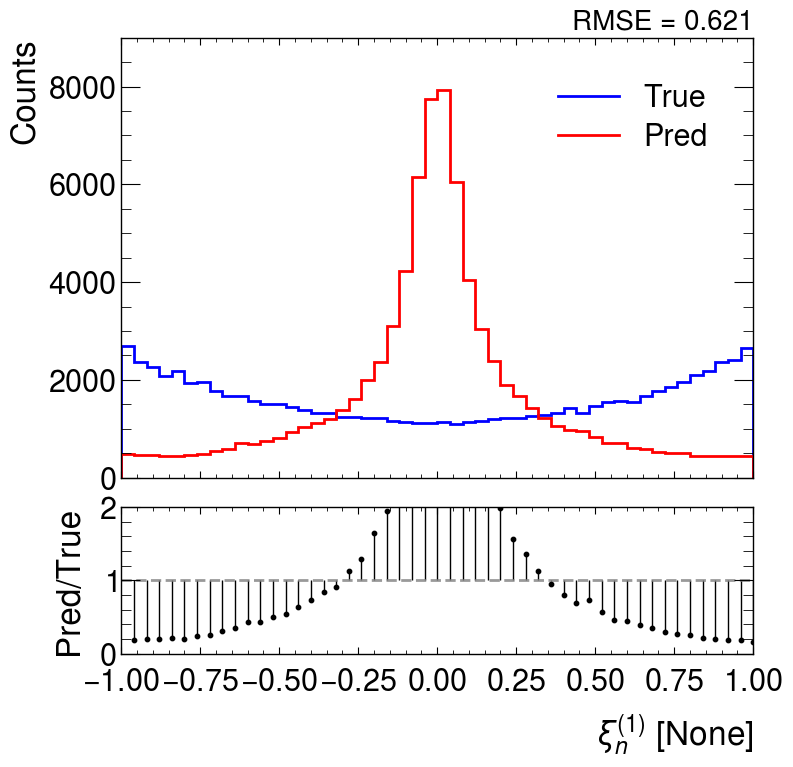

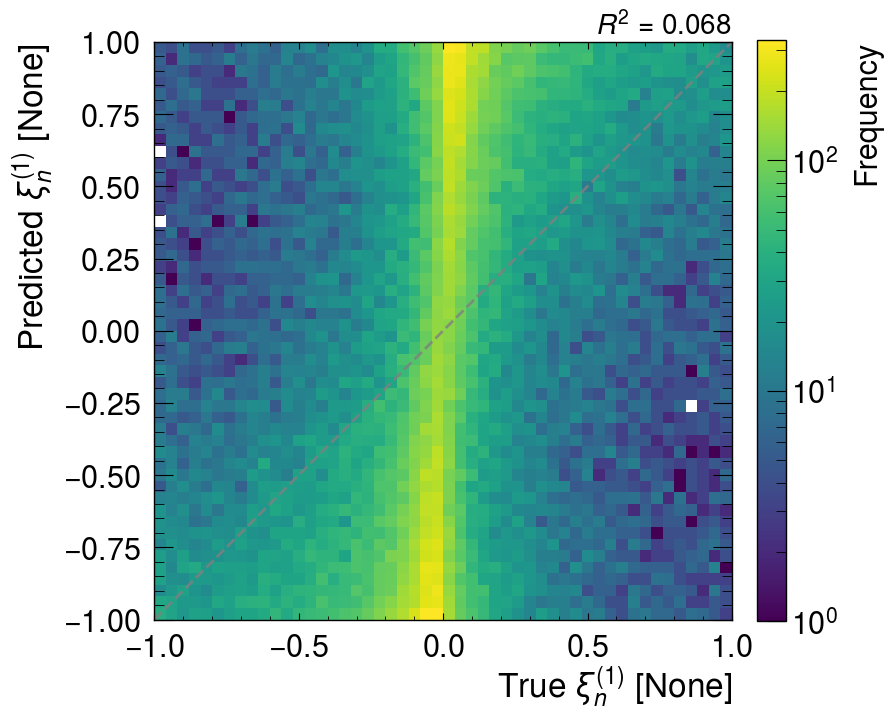

In [ ]:
set_range = [-1, 1]

plot.hist_1d(
    truth_xi_n[:,0], xi_n[:,0],
    title=f"RMSE = {np.sqrt(mean_squared_error(truth_xi_n[:,0], xi_n[:,0], sample_weight=None)):.3f}",
    xlabel=r"$\xi^{(1)}_{n}$ [None]",
    ranges=set_range
)

plot.hist_2d(
    truth_xi_n[:,0], xi_n[:,0],
    title=r"$R^{2}$ = " + f"{r2_score(truth_xi_n[:,0], xi_n[:,0]):.3f}",
    xlabel=r"True $\xi^{(1)}_{n}$ [None]",
    ylabel=r"Predicted $\xi^{(1)}_{n}$ [None]",
    xpad=0,
    ranges=set_range
)

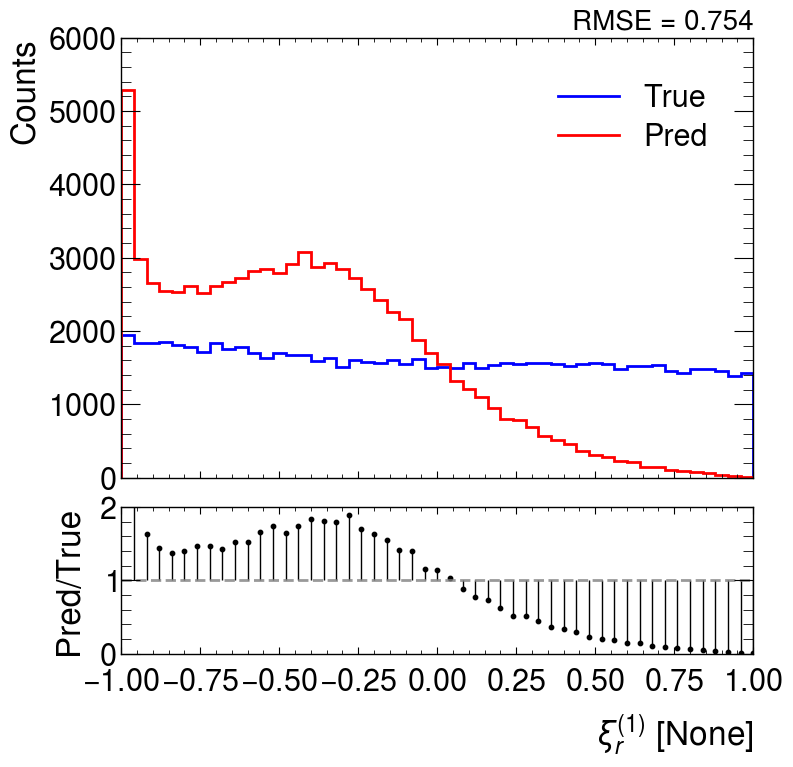

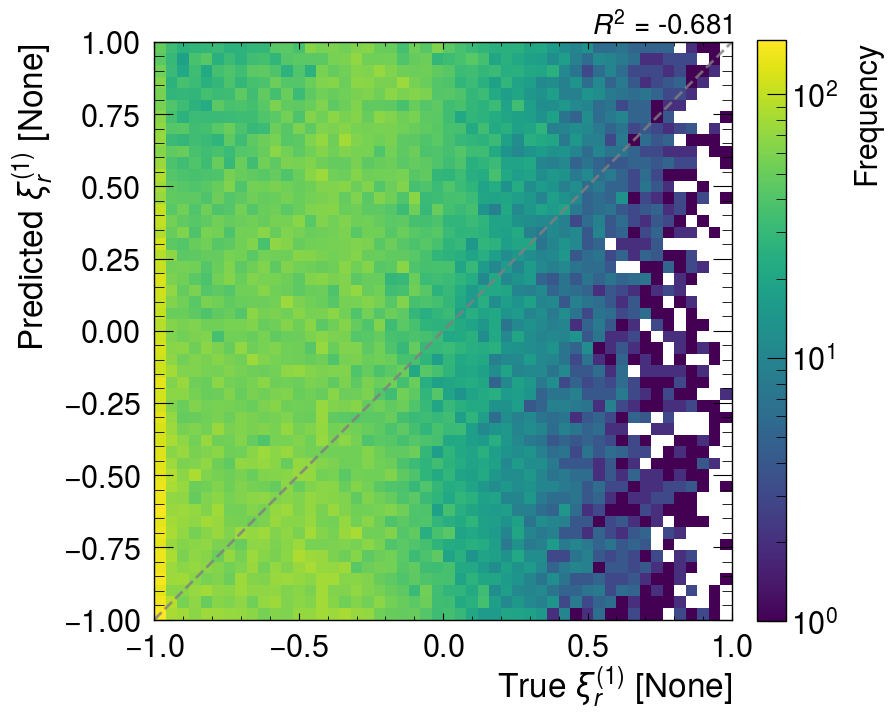

In [ ]:
set_range = [-1, 1]

plot.hist_1d(
    truth_xi_n[:,1], xi_n[:,1],
    title=f"RMSE = {np.sqrt(mean_squared_error(truth_xi_n[:,1], xi_n[:,1], sample_weight=None)):.3f}",
    xlabel=r"$\xi^{(1)}_{r}$ [None]",
    ranges=set_range
)

plot.hist_2d(
    truth_xi_n[:,1], xi_n[:,1],
    title=r"$R^{2}$ = " + f"{r2_score(truth_xi_n[:,1], xi_n[:,1]):.3f}",
    xlabel=r"True $\xi^{(1)}_{r}$ [None]",
    ylabel=r"Predicted $\xi^{(1)}_{r}$ [None]",
    xpad=0,
    ranges=set_range
)

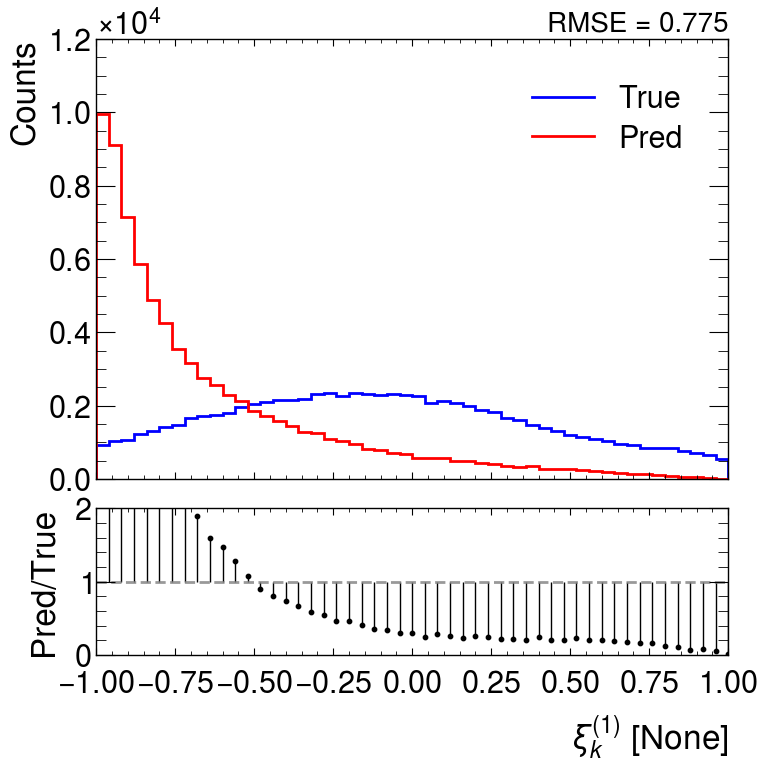

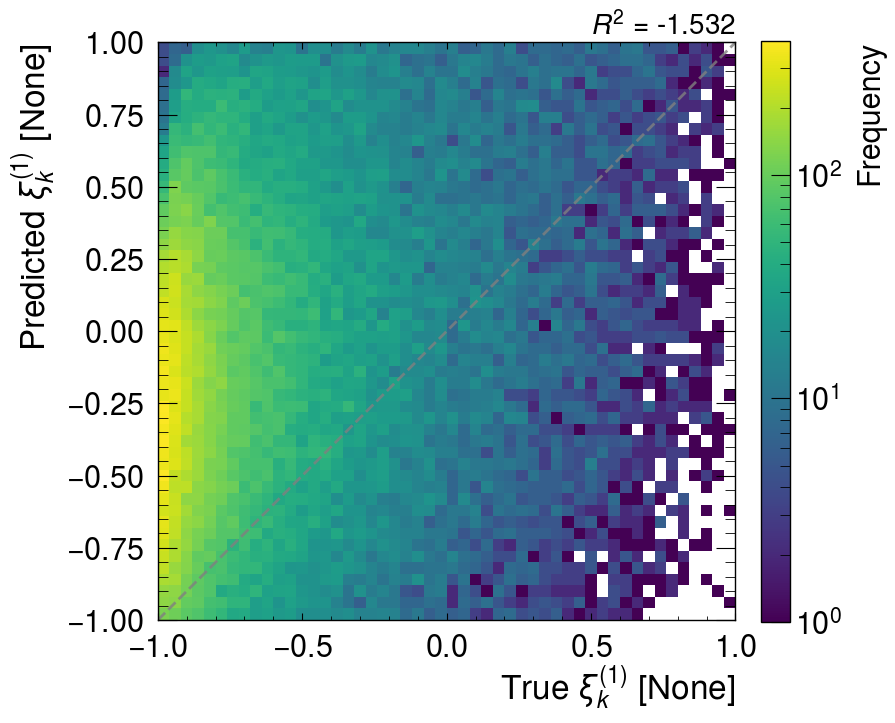

In [ ]:
set_range = [-1, 1]

plot.hist_1d(
    truth_xi_n[:,2], xi_n[:,2],
    title=f"RMSE = {np.sqrt(mean_squared_error(truth_xi_n[:,2], xi_n[:,2], sample_weight=None)):.3f}",
    xlabel=r"$\xi^{(1)}_{k}$ [None]",
    ranges=set_range
)

plot.hist_2d(
    truth_xi_n[:,2], xi_n[:,2],
    title=r"$R^{2}$ = " + f"{r2_score(truth_xi_n[:,2], xi_n[:,2]):.3f}",
    xlabel=r"True $\xi^{(1)}_{k}$ [None]",
    ylabel=r"Predicted $\xi^{(1)}_{k}$ [None]",
    xpad=0,
    ranges=set_range
)

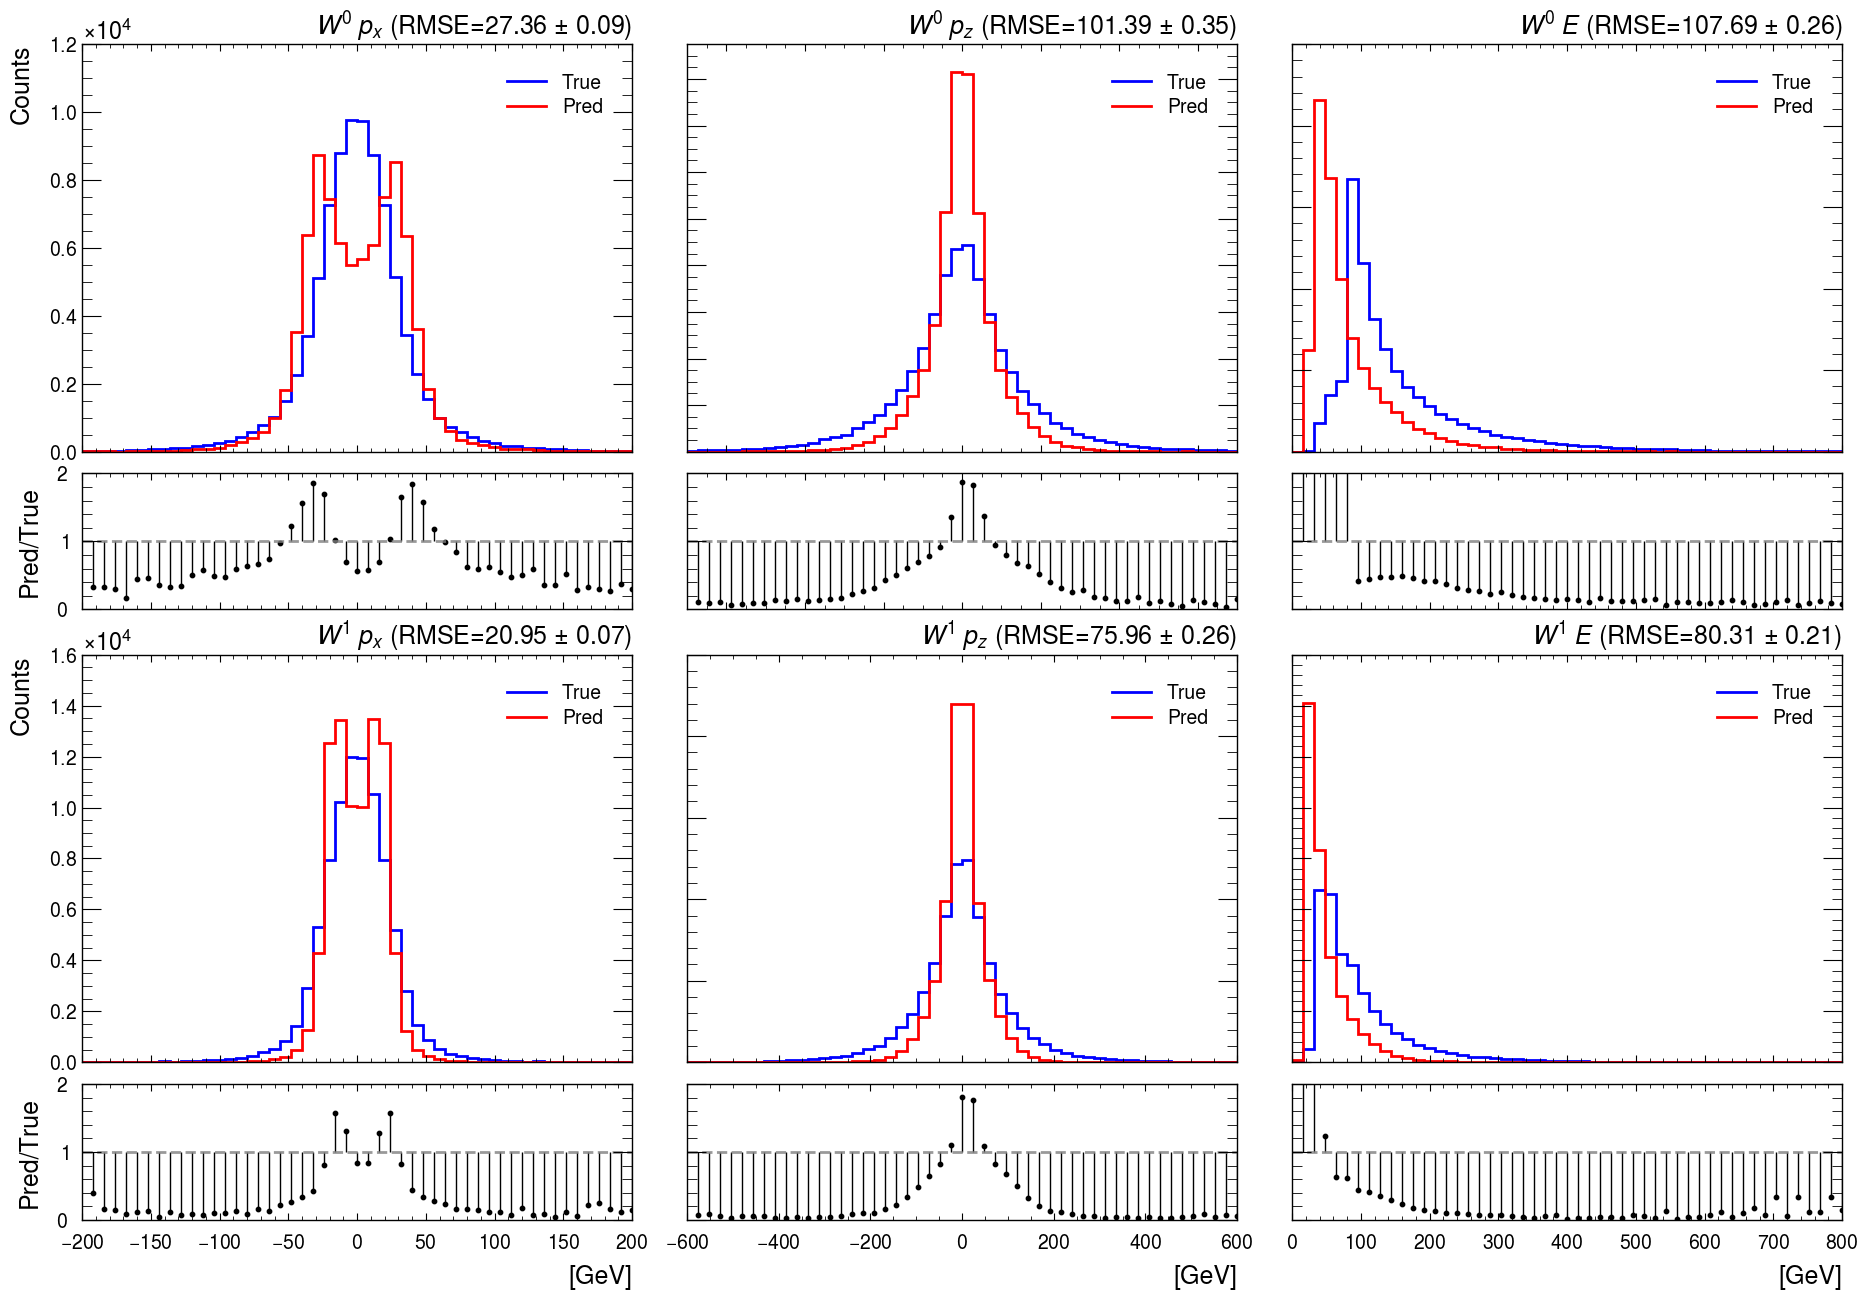

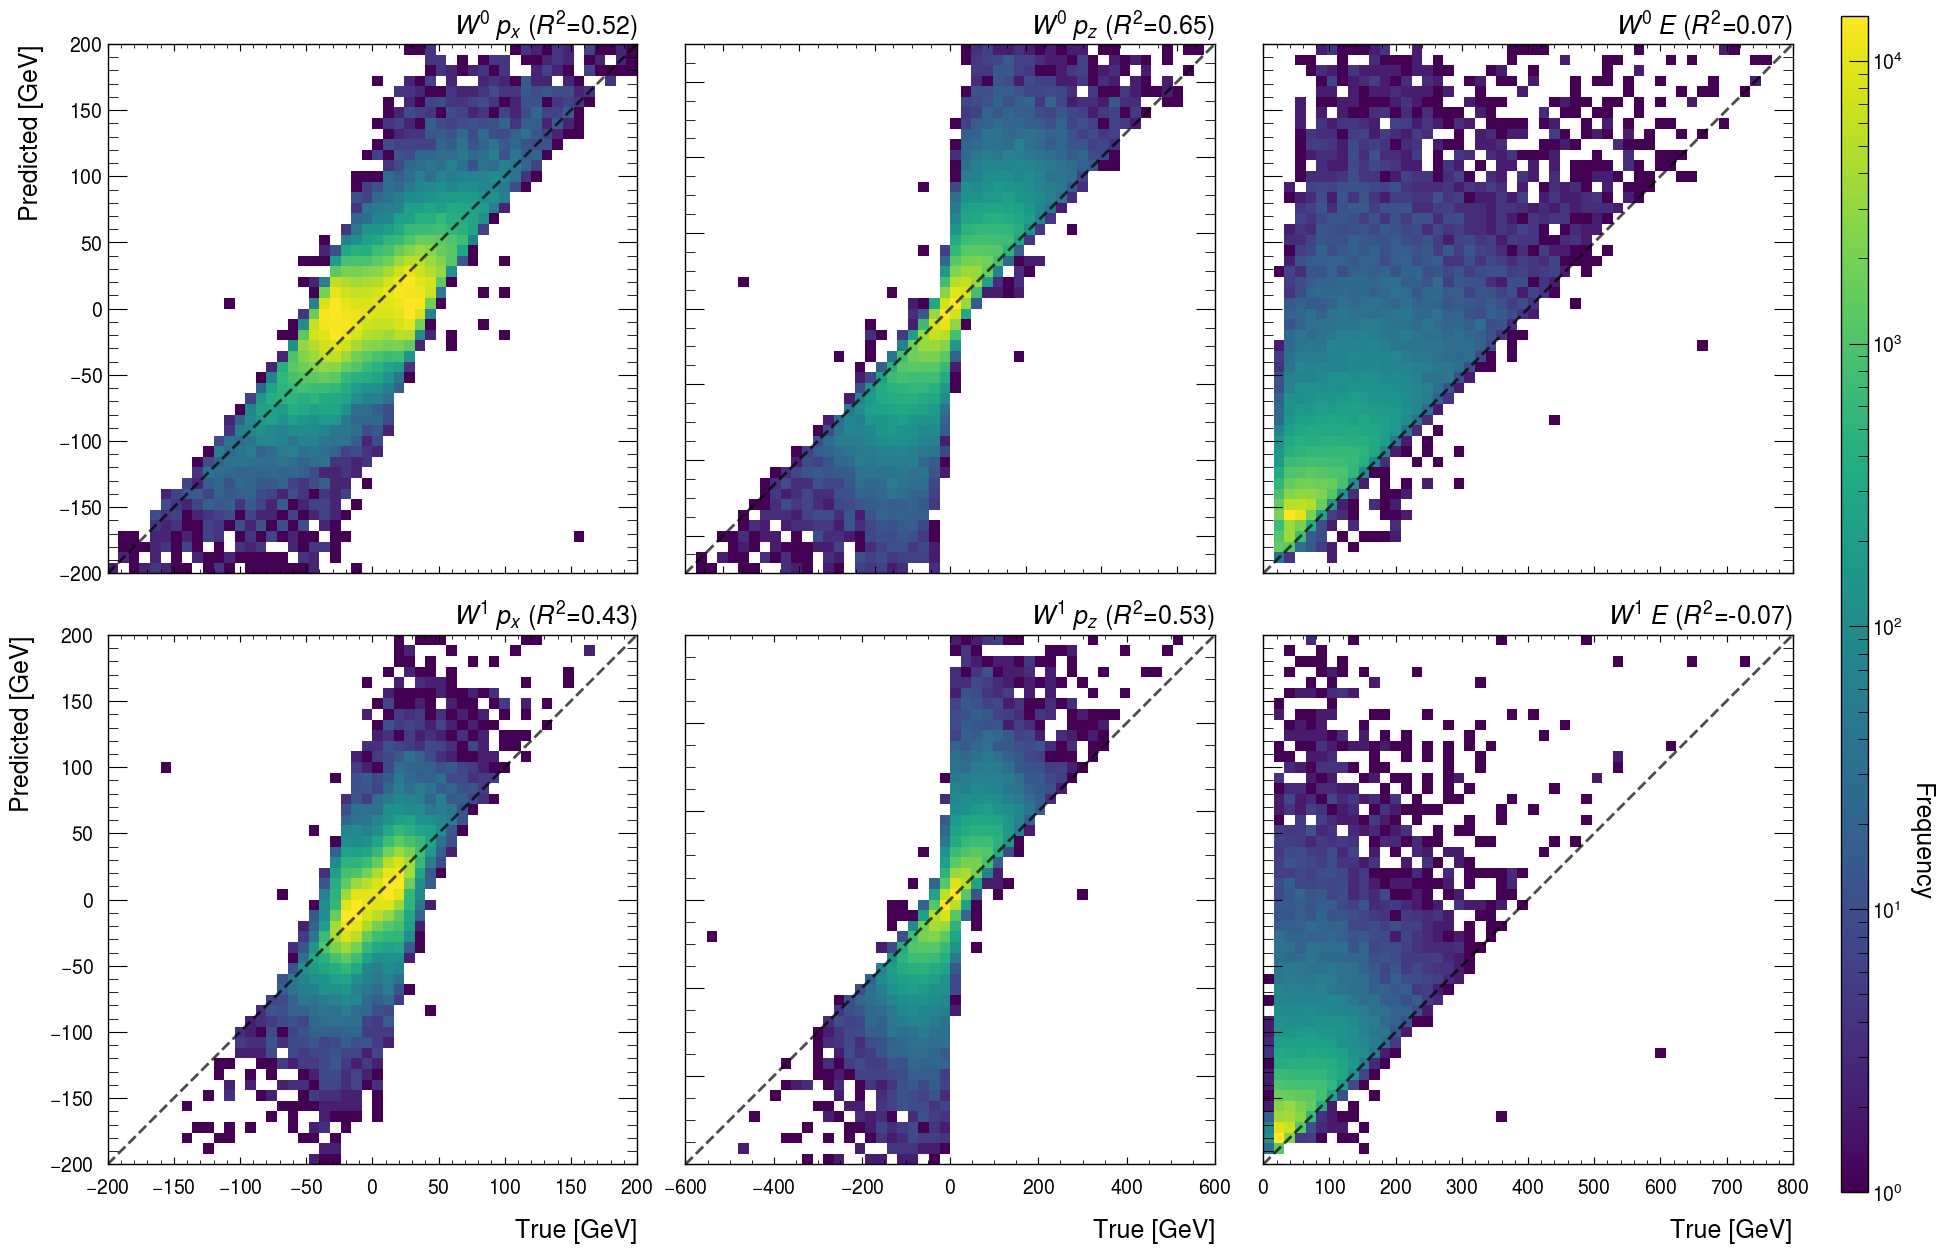

In [ ]:
w_plot_true = [
    sig_truth_inv[:,0],
	sig_truth_inv[:,2],
	sig_truth_inv[:,3],
	sig_truth_inv[:,4],
	sig_truth_inv[:,6],
	sig_truth_inv[:,7],
]
w_plot_pred = [
    sig_pred_inv[:,0],
	sig_pred_inv[:,2],
	sig_pred_inv[:,3],
	sig_pred_inv[:,4],
	sig_pred_inv[:,6],
	sig_pred_inv[:,7],
]
w_plot_ranges = [
	[-200, 200],
	[-700, 700],
	[0, 800],
	[-200, 200],
	[-600, 600],
	[0, 800],
]
w_plot_labels = [
	r"$W^{0}\ p_{x}$",
	r"$W^{0}\ p_{z}$",
	r"$W^{0}\ E$",
	r"$W^{1}\ p_{x}$",
	r"$W^{1}\ p_{z}$",
	r"$W^{1}\ E$",
]
plot.hist_1d_grid(
	w_plot_true, w_plot_pred,
	title=w_plot_labels,
	ranges=w_plot_ranges,
 	xlabel="[GeV]",
)
plot.hist_2d_grid(
	w_plot_true, w_plot_pred,
	title=w_plot_labels,
	ranges=w_plot_ranges,
	xlabel="True [GeV]",
	ylabel="Predicted [GeV]",
)

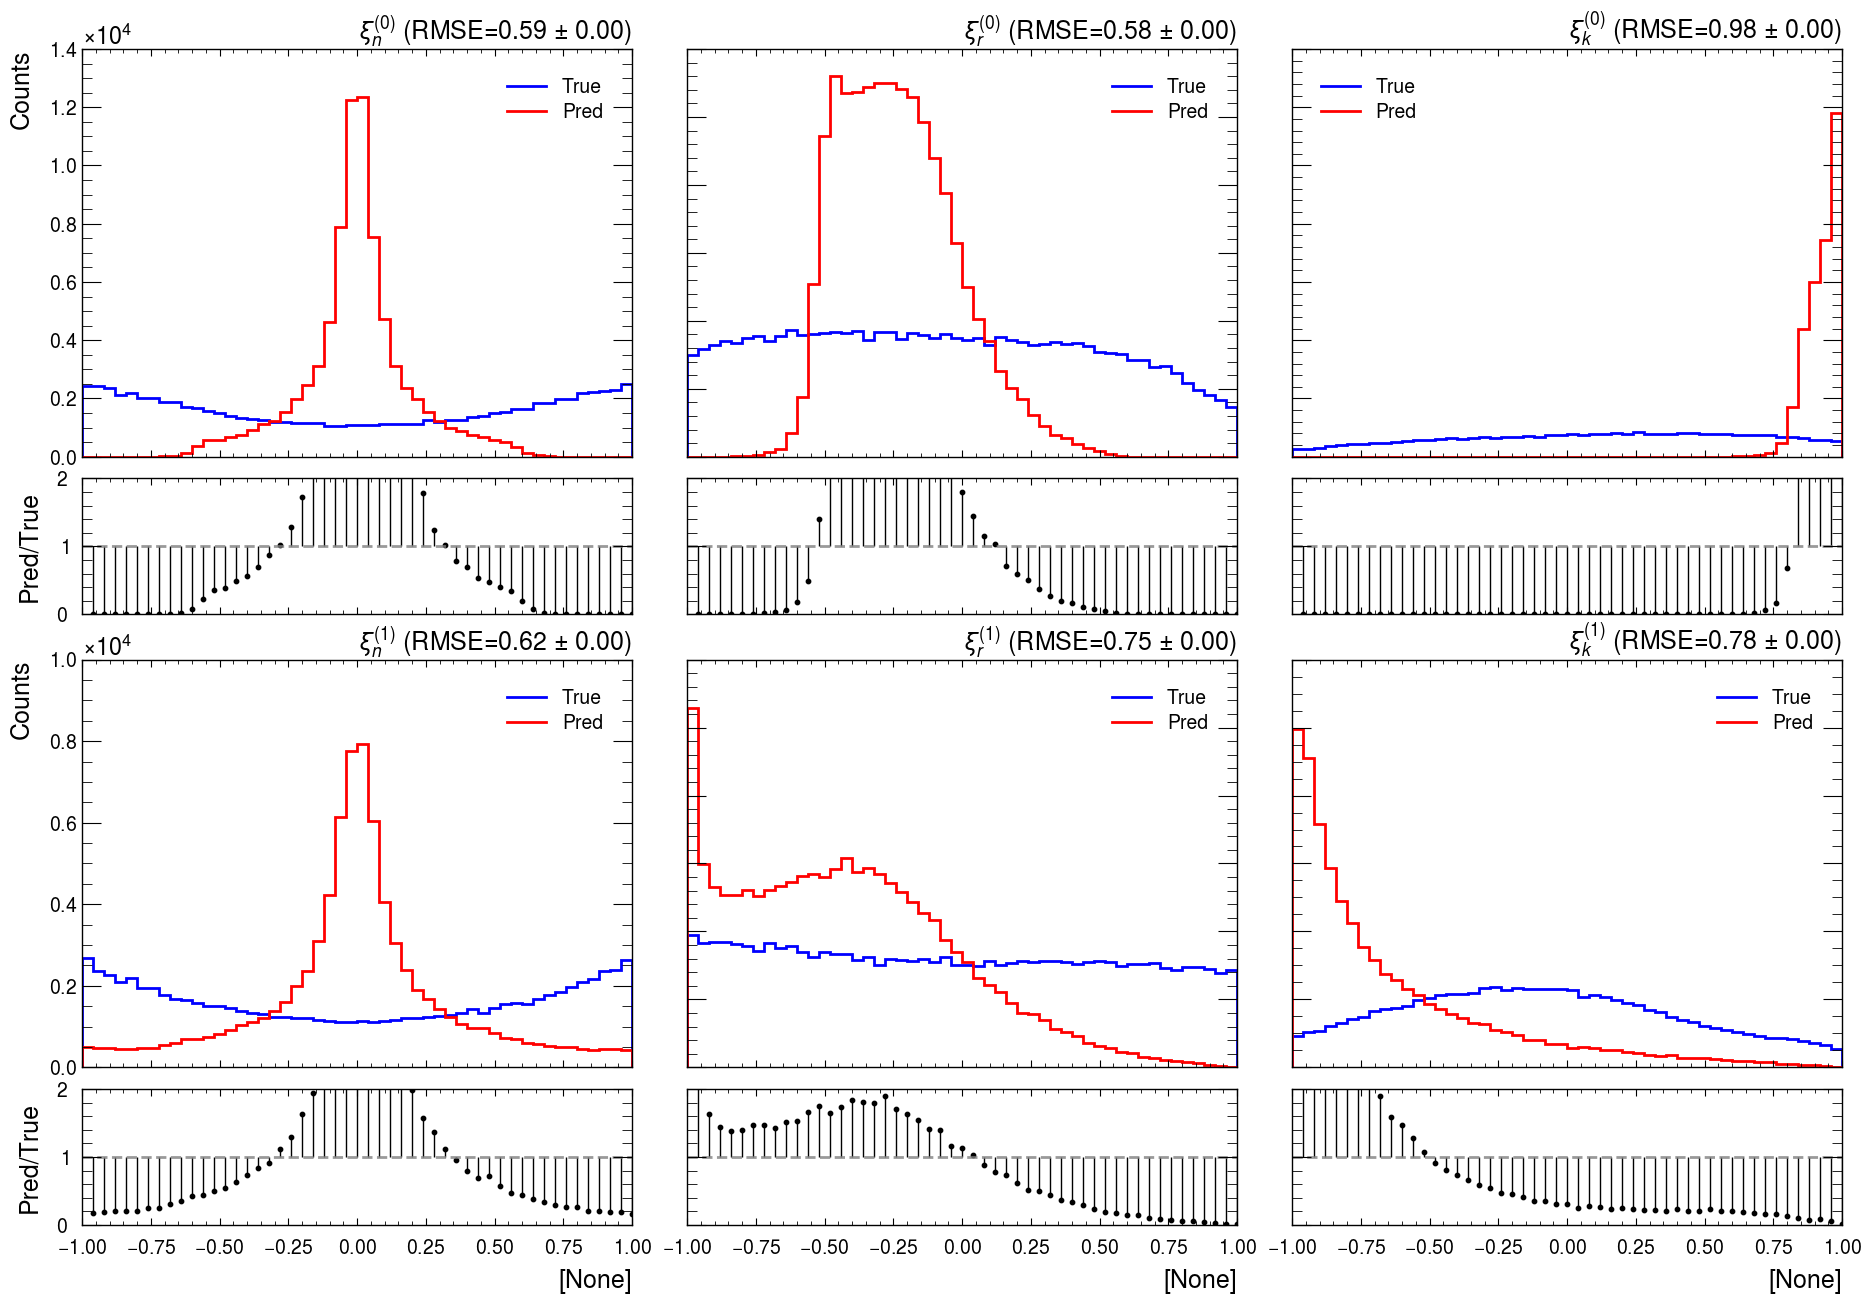

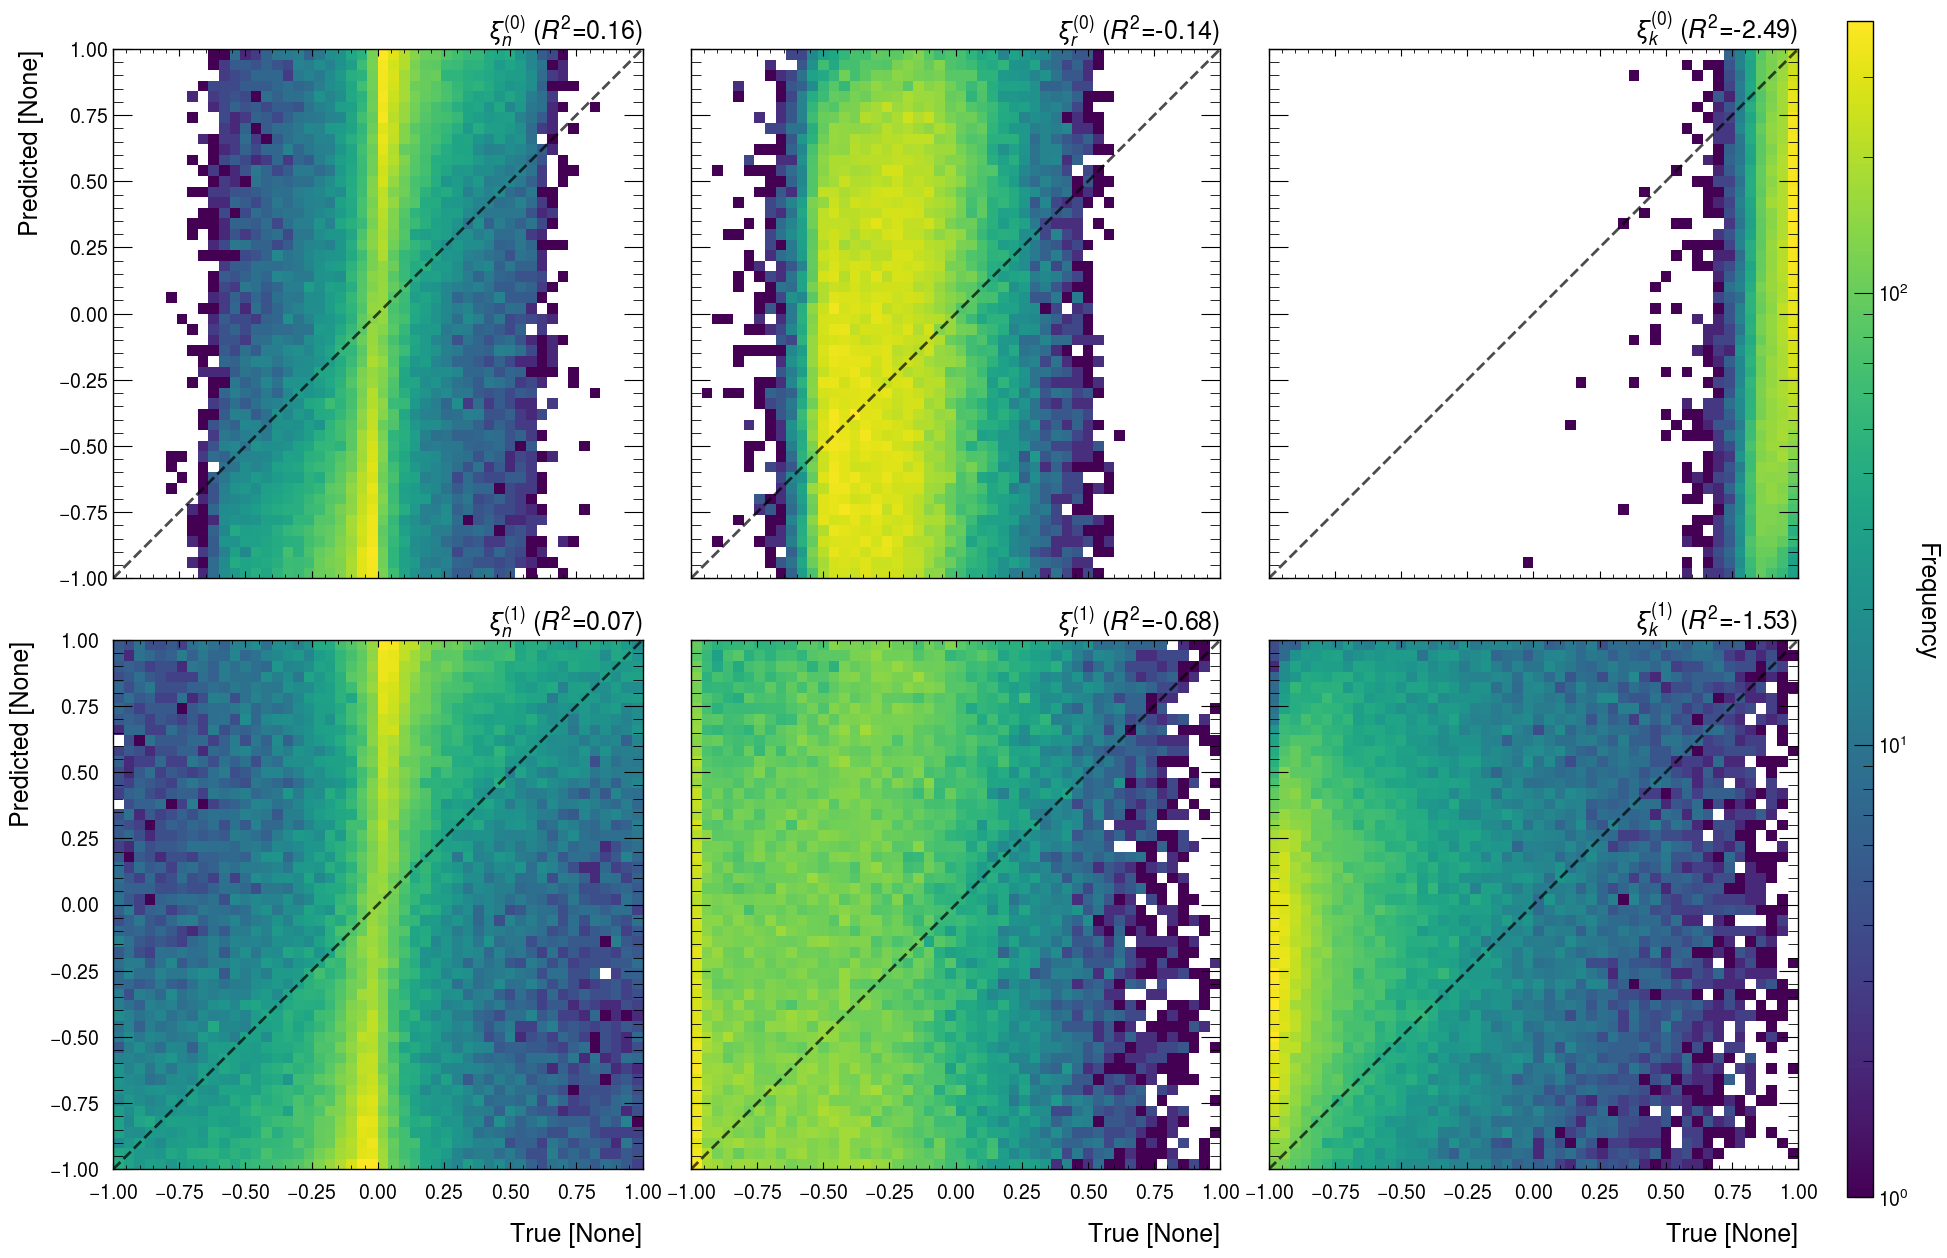

In [ ]:
xi_plot_true = [
	truth_xi_p[:,0],
	truth_xi_p[:,1],
	truth_xi_p[:,2],
	truth_xi_n[:,0],
	truth_xi_n[:,1],
	truth_xi_n[:,2],
]
xi_plot_pred = [
	xi_p[:,0],
	xi_p[:,1],
	xi_p[:,2],
	xi_n[:,0],
	xi_n[:,1],
	xi_n[:,2],
]
xi_plot_ranges = [[-1, 1]]*6
xi_plot_labels = [
	r"$\xi^{(0)}_{n}$",
	r"$\xi^{(0)}_{r}$",
	r"$\xi^{(0)}_{k}$",
	r"$\xi^{(1)}_{n}$",
	r"$\xi^{(1)}_{r}$",
	r"$\xi^{(1)}_{k}$",
]
plot.hist_1d_grid(
	xi_plot_true, xi_plot_pred,
	title=xi_plot_labels,
	ranges=xi_plot_ranges,
	xlabel="[None]",
)
plot.hist_2d_grid(
	xi_plot_true, xi_plot_pred,
	title=xi_plot_labels,
	ranges=xi_plot_ranges,
	xlabel="True [None]",
	ylabel="Predicted [None]",
)